# CS 109A/AC 209A/STAT 121A Data Science: Homework 8
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 16th, 2016 at 11:59pm

Clear namespace

In [1]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

Import libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Ploting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scientific computing
import scipy as sp

# Machine Learning
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn import tree


## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Hagmann, Tim]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

[-]

## Problem 1: Image Processing Revisited

In this problem we revisit applications of classification, with the purpose of comparing the performance of support vector classifiers with other classifiers we have learned. We'll begin with the aeriel vegetation detection problem from Homework #7.

The data is contained in `dataset_1.txt` and `dataset_2.txt` (you are encouraged to use the datasets from Homework #7 as well). The first two columns of the data contains the latitude and longitudes of randomly sampled locations in the satellite image, and the last column contains a label indicating whether the location contains vegetation (1 denotes the presence of vegetation and 0 denotes otherwise). The task is to, again, identify the vegetation regions in the image.


## Functions (necessary for the following calculations)

In [3]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='darkgreen', alpha=0.6, s=60, edgecolors="None")
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='black', alpha=0.6, s=60, edgecolors="None")

    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.2, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.grid()
   
    return ax

In [4]:
#--------  fit_and_plot_svm_for_c
# Fit and plot SVM model for value of 'C', overlayed on a scatter plot of data 
# (fit on train set and evaluate on test set)
#
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses)#      
#      x_test (array of test predictors)
#      y_test (array of test responses)
#      bounds (tuple of bounds for plotting)
#      C  (value for parameter C)
#      ax (axes to plot on)

def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1)):
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', ACC (Train) = ' + str(tr_acc)\
                           + ', ACC (Test) = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=200)
    
    return ax

In [5]:
#--------  kernel_switcher
# A Function to varying the kernels 
#
# Input: 
#      df_train (array of train predictors)
#      df_test (array of test predictors)

def kernel_switcher(df_train, df_test):
    # Select x-variables
    x_train = df_train[:, 0:-1]
    x_test = df_test[:, 0:-1]

    # Select yvariables
    y_train = df_train[:, -1]
    y_test = df_test[:, -1]

    fig, ax = plt.subplots(1, 4, figsize = (30, 7))
    kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
    
    # Fit models
    for i, kernel in enumerate(kernel_list):
        
        # SVM
        svm_fit = svm.SVC(C=10000, kernel=kernel)
        svm_fit.fit(x_train, y_train)
        sv_indices = svm_fit.support_
        ax[i].scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100)
        
        # Train and test error
        tr_acc = svm_fit.score(x_train, y_train)
        ts_acc = svm_fit.score(x_test, y_test)
        
        # Plot boundaries
        ax[i] = plot_decision_boundary(x_train, y_train, svm_fit, 
                                       str(kernel) + ' Kernel'+', ACC (Train) = ' + str(tr_acc)\
                               + ', ACC (Test) = ' + str(ts_acc), ax[i])

In [6]:
#--------  fit_and_plot_dt
# Build a decision tree and plot the data
# Input: 
#      df_train (array of train predictors)
#      df_test (array of test predictors)   
#      depth (depth of tree)
#      ax (axis)

def fit_and_plot_dt(df_train, df_test, depth, ax):
    x_train = df_train[:, 0:-1]
    x_test = df_test[:, 0:-1]
    y_train = df_train[:, -1]
    y_test = df_test[:, -1]
    
    # Tree
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = dt.score(x_train, y_train)
    ts_acc = dt.score(x_test, y_test)
    
    # Plotting
    ax = plot_tree_boundary(x_train, y_train, dt, 'Depth = ' + str(depth)\
                           + ', ACC (Train) = ' + str(tr_acc)\
                           + ', ACC (Test) = ' + str(ts_acc), ax)
    
    return ax

In [7]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # Plotting
    ax.scatter(x[y==1, 0], x[y==1, 1], c='darkgreen', alpha=0.6, s=60, edgecolors="None")
    ax.scatter(x[y==0, 0], x[y==0, 1], c='black', alpha=0.6, s=60, edgecolors="None")
    
    # Preparation
    interval = np.arange(0,1, 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Astetics
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.grid()
    
    return ax

### Step 1: Load the data and explore

Let's load the two datasets and visualize them.

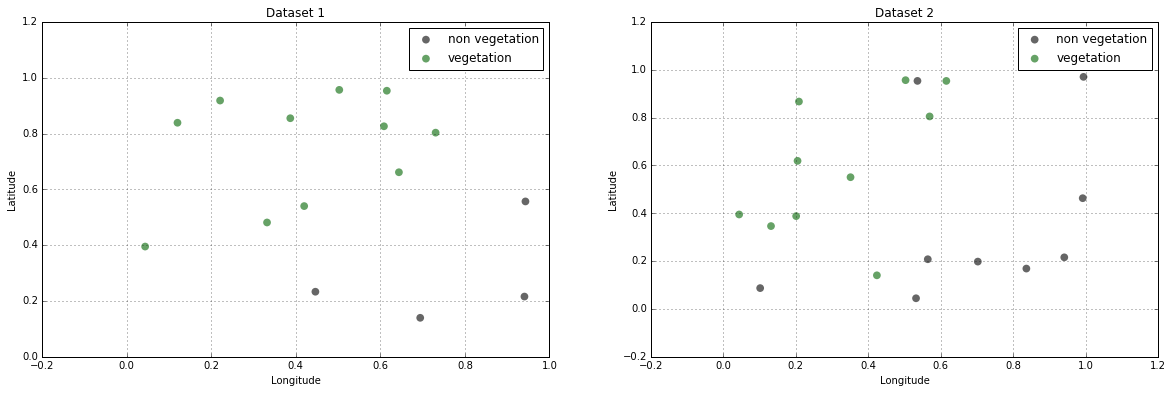

In [8]:
# Load dataset_1
data_1 = pd.read_csv('datasets/dataset_1_train.txt', delimiter=',')

# Load dataset_2
data_2 = pd.read_csv('datasets/dataset_2_train.txt', delimiter=',')

# Plot data
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

#Plot dataset 1

x = data_1.values[:, :-1]
y = data_1.values[:, -1]

ax[0].scatter(x[y==0, 0], x[y==0, 1], label='non vegetation', c='black', alpha=0.6, s=60, edgecolors="None")
ax[0].scatter(x[y==1, 0], x[y==1, 1], label='vegetation', c='darkgreen', alpha=0.6, s=60, edgecolors="None")

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Dataset 1')
ax[0].legend(loc='best', scatterpoints = 1)
ax[0].grid()
#Plot dataset 2

x = data_2.values[:, :-1]
y = data_2.values[:, -1]

ax[1].scatter(x[y==0, 0], x[y==0, 1], label='non vegetation', c='black', alpha=0.6, s=60, edgecolors="None")
ax[1].scatter(x[y==1, 0], x[y==1, 1], label='vegetation', c='darkgreen', alpha=0.6, s=60, edgecolors="None")

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Dataset 2')
ax[1].legend(loc='best', scatterpoints = 1)
ax[1].grid()
plt.show()

It looks like the classes in dataset 1 is well separated, while the classes in dataset 2 is not. That means that while dataset 1 has no overlapp of the points dataset 2 has some.

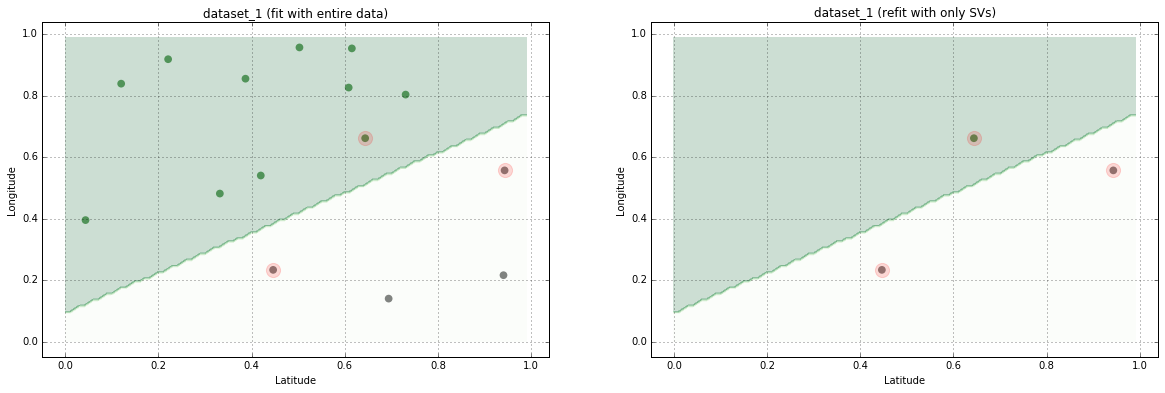

In [9]:
# Load dataset_1
x = data_1.values[:, :-1]
y = data_1.values[:, -1]

# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_1 (fit with entire data)', ax[0])

# Highlight the support vectors
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=200) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_1 (refit with only SVs)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=200) # draw circles around SVs
plt.show()

The above plots show, that the support vectors are the points used for calculating the hyperplane decision boundary. Removing the other points (done in plot two) has no effect on the decision boundary.

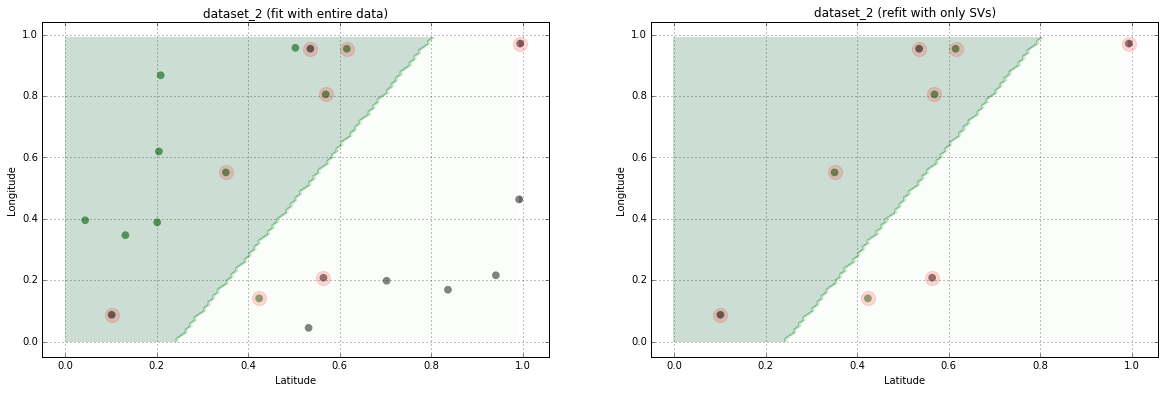

In [10]:
# Load dataset_1
x = data_2.values[:, :-1]
y = data_2.values[:, -1]

# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_2 (fit with entire data)', ax[0])

# Highlight the support vectorsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABI0AAAGJCAYAAAAHYcOFAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xt4XFd97//30ugyI2k8uku+SY4tjS07dowiW8Zc4jq/EkrDgdIDFErbtL/T9pxDD/Tp0x89Pb+eUvhRaHvap9CWpwdaSk5oKS3QEgIJlAYkLkmIcr9bsWMpjmNHkW+SLGlkadbvj71HHksjWbZn1uyZ+byeR4+9Z7Zmlr5WpE/WXt+1jbUWERERERERERGRdGX5HoCIiIiIiIiIiASPJo1ERERERERERGQJTRqJiIiIiIiIiMgSmjQSEREREREREZElNGkkIiIiIiIiIiJLaNJIRERERERERESW0KSRiIiIiIgUJGPM540xH833OFwxxmw3xgxe42t83hhz2hjzgDHm9caYZ7M1vrT3eK8x5lsrPH+TMeZYtt93mfc6aow56OK9VsMYc6sx5kv5HofIamnSSOQalHpQMcbEjTGPGmPOGWN+wxjz18aY/zcH73u3MeYXVng+b/8OlwtFWXj9DxtjvpCj11ZoERGRkmGM+Z4x5leC8j7GmGZjzBeNMceNMWeMMT8wxuy9zKd9FPiTaxjb64GbgXXW2n3W2h9aa7vTns/KBIu19ovW2jenvW7SGLN58WnX+j65ZIyJGWM+Z4w54Wfd54wxH/Kfe9YYc1uGz/mgMebBlV7XWvsNYLsx5vrcjFwkuzRpJOJIkQaVDwHftdbGrLV/Za39L9baP/RfP2tXkKy1b7HWfsF/3V8yxvwgG697pYwxHX7oWfjZuTgU5ciqQtWVTp4ptIiIiORVLfAg8BqgAbgD+KYxpjrTycaYNuAAcOcyz4dW8Z6bgGFr7cxVjPdaBHqCaBl/DtQAW621MeA/AIf95/4P8IsZPud9wO2reO0vAb+ehTGK5JwmjURKVzaCSgfw9DKvb8hNQMjV617Je5tVnby68JZvCi0iIlIwjDGvMcY87K/8+BIQTnuuzhhzlzFm1Bhzyv/7Ov+5jwFvAP7KGDNujPkL//FPGmNe9F9v0F+Jk3q9Pf5j5/zVJn+a9tw+Y8yP/AtvjxpjblrpfTKx1h611n7SWjtqPX8DVAJbl/mUnwQesdbOpo3jqDHmQ8aYx4FJY0yZMWatMeYrfh2OGGP+m3/urwB/A7zWH9uH0y/yGWPuANqBu/znfztD/fuNMT/j//11/sW0n/KPDxpjHvX/vnCRzxgzgJednvBf950XX878ljHmFf8i5m3L1cr/mu70/12HjDH/Ke25Dxtj/skY83/813/SGNOT4TVajTHnjTH1aY/1+HXKlNn2AF+01o4DWGuHrLX/4j/3BeD1xpiNaa+1HdiJl60wxtzm13/c//M9aa/dD/z0cl+vSJBo0kjkCiioXAwqxph7gZ8APu2/V6fxV7oYb+LpbmCdMWbCf75tUS03GWPOpB3/jTHmlbTjO4wxH/D//j1jzK8YY7YBf40XdiaMMafTXrLBGPMN/73uN8Zct9zXvlz90t7ro8aYH/qv9S1jTIP/9ID/51n/uT6zaOWTH57+qzFmCBjyH9tmjPk3//vi2bSwlGlsm/xAds4Y822gadHz/+x/P5zxz+v2H/9V4OeBD/lju9N//HeMMYf9x54yxrx90Vv2o9AiIiIFwBhTAfwr3iqPBuDLwM+mnVIG/B2wEW/yYwr4NIC19veAHwC/Ya1dY639gP85DwK7gHrgi8CXjTGV/nOfAj7przLZAvyzP451wDeAj1pr64HfBr5qjGlc4X1W8/XtBiq4uJplsZ3AoQyP/xzwU0Ad3sWtu4BHgbV4rWgfNMb8pLX274D/DNzvj+0j/udbv0a/CLwI3Oo//6csNYB3ERHgjcAR/0+Am/ByRUrqdVM5a6f/ul/2j9uAKLAO+E94mTK2zNf+T/7Y2oB3Ah83xhxIe/6teP9+Mf/r//TiF7DWvgJ8D3hX2sPvA/7RWjuf4T0f8N/nNmNM56LXOu5/renbJ7wPuNtae9rPwp8CbrHWrgH2A4+lnfss0GGMqV3m6xUJDE0aiaySgsqlQcVae7P/Xu/33+tw2nNTeOHlZWtt1H/+ZPqLWWuHgXPGmNf4D70BmDDGpCatFgcPrLXPcTHsRK21DWlPvxv4MF5gOgL84TJf57L1SzvtPcAvAc1AlX8OXAxFa/yv6cepoS16m7cBe/Fav6qBfwP+Hm8C6OfwQtG2TOPD+z4Y9M/9mD+OdHfjfT+0AI/45+NP+v0D8Cf+2N7mn38YeJ0fWD4C/L0xpjXt9RRaRESkUOwDyq21f2GtnbfWfhXvdyYA1trT1tp/tdYmrLXngU9w8Xd3Rn6b+VlrbdJa++d4v/dTWWQW6PQz1pS1NrVXzfuAb1prv+2/xr3AQ8BbrvYLM8aswVv1/QfW2ollTqsDMj33KWvty9baBN7qmCZr7R/6NRoG/hYvf6x6OCs8N4CX0cCr7SfSjm/i4gW21bzuLPD/+eO8B5gkw8VLY8wG4LXA71hrL1hrH8f7mtLbw35orf22tdbirQLatcwY7sCf6DHedgPv8c/P5Dfw8tv7gaeNt8IpfUuChRY1Y4zBu3h3e9rz88BOY0zYWvuKtTZ9w/EJvHrULfPeIoGhSSOR1VNQyRxUrsX3gZvSJjG+4h9vAqLW2ieu4LX+1Vr7sLU2iTd5snuZ81ZTv89ba4/44eufM7zW5drTPu7/uyaAW4Gj1to7/BVdjwP/gneV7NIX9ZY49wK/74eiH+BdLVtgrb3d/364gLfH1A3GmOhyA7HWftW/soZ/Ze95vAmtFIUWEREpFOuA44seG0n9xRgTMcZ8xhgzbIw5izeBUef/D31GxpjfNsY846/gPQOs4eIq3/8bL5c9Z4z5sTEmtTK3A3iX8e5Adtr/vNfhrYK5YsaYMPB14D5r7UqbXJ/BW5mz2Etpf+8A1i8a2+/iXWzKhvuBuDGmBbgBLz9u9C++7cXLdqt1ys9tKVN42ycstg447V+UTBkB1qcdp1+cnALCJm0PyjR3At3GmA7gTcBZa+1DmQbnZ/o/stbuARrxLhh/2RiTykz/ArQZb0/QnwAieBf3UhdQ3w38F+CE8ToQ0ifEongXHc9mem+RINGkkcjqKahkDirXYgDvl+wb/b/34y15vglvFdOVWBwWlls5s5r6rfa1lrM4vO1b9H7vJfO/1zrgjLV2Ou2x9O+xMmPMH/ntZmeBo3iBo4llGGN+0XgteKnvsR2LzldoERGRQnGCSycKwFvdnfLbQBewx1pbx8WLd6ksdsnKYONtC/D/AP/RWlvvr0AeT53vX0B6r7W2Ge9GIF8xxkSAY8Ad1toG/6PeXwH9vzK9z0r8FeZfA1601v7ny5z+BBDP8Hj6+x0DXlg0tpi19q2rHNKKY/czysPAB4GnrLVzeBNJvwUcttaeXunzr9LLeNsQ1KQ91s7SXH5ZaRcEfwHvQuKq7lBrrZ0EPo63MfZ1/mPTeBc8f8l/rS/59Uh9znestW/Cy3yH8PaTSunG25B88kq/BhHXNGkksnoKKpmDynJWM44BvLa01HLmH+FN4Ky0vPlaN8G+XP1Wstr3Xhze+he93xpr7fszfN4JoN7/d05J/x77ebye/YP+99gmvO+X5b7H2oHPAv817XvsaS5dKaXQIiIiheJ+YM4Y89+MMeXGmHdw6erZWmAaGDfefoR/sOjzXwHSb/seBS4Ap4wxlcaY3yftApkx5ueNMakLLefwfs8m8VqW3mqMeZN/QSdsvA2l1y3zPhkZY8qBr+JdoLrt8l8+3wF60rYyyORBvHb/D/njChljdhhjelfx+uBdOLvc2L+P17qVymr9i46v9nUzsta+BNwHfMIYU2WM2YV3cXWlCZ+VVoV/Aa/eb13pNYwxv2eM6TXGVBhjqoDfxLuImr6v1B14K4regdeulvrcFmPMf/C3KbiA13qXvm/STcA9K4xRJDA0aSSyegoqlw8q6V4BGv3Wt4ystw/SNN7VmQG/Ne4VvF+8ywWPV4ANxttj6mpcrn4reRXv32DLFbzfN/CWcb/P/76p8APIkj2NrLUv4rXKfcQ/7/V4gSalFkgAZ/yrbZ/g0omixf/2Nf54x/yv9ZeB6xe9rUKLiIgUBL81+x3ALwOn8Fq9v5p2yieBamAMb5Lh7kUv8Sngnca7McUngW8B38a7ccVRvEx0LO38N+PtZTOOd/v1d/stSy/h7V/4P/CywQjexcOyZd5nOfvx2uPfhLfPY+rmIa9b5usfBb4LpN/Uwi46J4nXGr/b/5pG8Va4LJvHFvkj4H/6q6N/a5lzBvAyyfcXHa80afQHwB3+6/7HZc5Z6eLce/BW+LyM92/+P62131vhfLvM37HW3oeXjx6x1h5jeRb4PN6/8XG8TcXfkt4mZ639Pl5OP2atfTjtc8vwVl8dx/t+fCNeq1r61/OZFd5bJDistfrQhz5W+QH04G0+fA74R//jo/5za/HuyDABPAf8Kt4VhTL/+X14VyZO4YUaA3zOf63jeGHjBbxVJOBd+XgFb/XRk8Bb08axB++qzin/nLuADZneZ4Wv5Y3++Cb9MU/47/W6FT7nn4B3pR1/F/iVtOO/S9XDP/5bvF+Up4G2ZV7zi3jLmVPH/wuvVcpkeh+8zbrv8r++Uf+xzy9635vwVk8t93WsVL/FX9MvAd9PO/4DvAB2Gm/ScPHz88DmRe/XhTd5NIoXPP4d2LXM2DbhhbBxvCD7F3gro8CbBPqa/9xRvMm2hfcDOvHulnIa+Bf/sY+lagX8Kd73aPrX9wTe3Uzy/t+XPvShD33oQx/6WPkDb4Xwj/M9jkL/AO5Nz0OO3/tWvFa2vNdBH/pYzYex9lo7PUSkVBjv9u63W2v78j0WuXbGmFuB91lrr+SOKiIiIiIFyxizB+/C3Ebr3bxGRFagSSMREREREZEc8FvN7+HSFikDWGvtalvGJEuMMbfjtRZ+wFq7qk2wRUqdJo1EipiCioiIiIiIiFwtTRqJiIiIiIiIiMgS5fkewGoZYzS7JSIiUuSstSvdJlnyQBlMRESk+C2XwcoyPRhUudoN/MMf/nDedyQvpQ/VW7Uu1g/VW7Uu1g9X9ZbgKvTvLX2o3qp1cX+o3qp1sX4EIYMV1KRRrgwPD+d7CCVF9XZHtXZL9XZHtXZL9ZZc0feWW6q3O6q1W6q3O6q1W0GotyaNRERERERERERkCU0aAbfddlu+h1BSVG93VGu3VG93VGu3VG/JFX1vuaV6u6Nau6V6u6NauxWEehfM3dOMMbZQxioiIiJXzhiD1UbYgaMMJiIiUtxWymBaaQT09/fnewglRfV2R7V2S/V2R7V2S/WWXNH3lluqtzuqtVuqtzuqtVtBqLcmjUREREREREREZImctqcZYz4H3Aq8Yq3dtcw5fwH8FHAeuM1a+9gy52lptIiISBFTe1r2KIOJiIjIauWzPe3zwC3LPWmM+Slgi7W2C/h14H/neDwiIiIipUAZTERERK5ZTieNrLU/BM6scMrbgDv8c38MxIwxrbkcUyZB6BMsJaq3O6q1W6q3O6q1W6p34VEGk0xUb3dUa7dUb3dUa7eCUO9872m0HjiWdnzcf0xEREREckcZTERERC4rp3saARhjOoC7MvXTG2PuAj5hrb3PP/534EPW2kcynKt+ehERkSKmPY2ySxlMREREVmOlDFbuejCLHAc2ph1v8B/L6LbbbmPTpk0A1NXVsXv3bg4cOABcXLalYx3rWMc61rGOC+O4v7+f22+/HWDh97s4owymYx3rWMc61nGJHvdfQQZzsdJoE95Vrp0ZnnsL8H5r7U8bY/YBn7TW7lvmdXJ2lau/v3+hkJJ7qrc7qrVbqrc7qnWOWet9lJUB7uqtlUbZpQwmi6ne7qjWbqne7qjWORbADJbTlUbGmC8CB4BGY8yLwIeBSsBaaz9rrb3bGPMWY8xhvNu9/nIux7OcQyeOEj3alI+3LkmqtzuqtVuqtzv3Pnc/w3VjtMTq2NXcRayyjkh5db6HVdishYkJOHmS8nOTFx+vr4fz573njeZzCkUhZLCHjz6ln5uOqd7uqNZuqd7u/POj9zBcN8YN6zfTHGmkrXpdvodU+AKewXK+0ihbcnmV6+GjT+XkdUVEJLuGxkY4MTnK6NQo+7ftYn20iXhdXBNG12pmBp5/3gsmVWHKa9d44cRamJqCRAKqqyEeh3A4Z8PQSqNgylUGU/4SESkcQ2MjHDp1mJamejbUN9PTul0X7bKhADKYJo1QaBERKQTpYWVdXQO9bTsVVrJhZgaefsZbBl1TTdJaXj72MvPz82zcuJHKykrvvPPnIZmEHTtyFlo0aRRMmjQSESltA8ODjCfGaWyMsr9jJ63VLVphlA2LMtiFCxc4fuxlKisr2bhxIya1uijPGSzfG2EHwkMPDNK7b0++h1EyVG93VGu3VO/cSYWVvVt30FoT45XHX6Fts8LKNbPWu7rlh5UXX3yRgYHv88LhFwCoqqri4MGDzIZCHOjr80LL0BDs3KlWNckK/dx0S/V2R7V2S/XOnYHhQRrqo3RG2+hp3c4T9z/JDTfvzvewCt+iDPbII4/w6COP8tIx754UdXV1vP3tb+fY2FjeM1iZ03cTEck1a72Z+CAJ4pgK0MHr++hYs5bW6haqQrlbnltSJia8EFJTzZkzZ/j2t7/N5PmLvfSJRIJ77rmHIy94k0jU1HhLpScm8jRgEREJrCDmnSCOqQBtbtrAxjWtxCrrlMGyJS2DPfvss/z4wQeZnbuw8PTZs2f5h3/4B8ZTmSuPGUwrjUCz0o6p3u6UTK2tpWzyPOWvjlE+Pr7w8NyaNcw1N5GsrXEyI39JvQMypmJ104Gb8j2E4nDyJFR54e/pp55mbn4+42kXzp27eFBV5X3emjUuRihFrmR+TwWE6u1OydQ6IHlHGcwdZbAsSctgjz/+RMZTLly4QDh90jNPGUyTRiISONZa5pPzlIcu/yPKJBJUHR2hbHoaW1nJfDS6sHlcaHqa8sNHSEYiJK7rwFZVORh9MMdULGaTCaA238MoHmfPQiwGwOkzp5c9bXR09OJBdTWcOZPrkYmISMAFMe8EcUyFbGhsBIDJC5NEqxryPJoi42cway1nzi6fq4KQwdSehtcDK+6o3u4UWq3n5uf47nPf5c+/8+f88bf+hP898BkeP5Z55h28YBAeOoKZn2c+FiMZiTA3P8/k+UmS1pKMRJiPxTDz8955iUROx//QA4MZxzRzIcGF+QtgjPMxFbqhsRHuOnQv4WiI0zNjNEcaiVXWMdA/kO+hFb7UlSv/amu0Nrrsqa+eP3/xIHV1Vsv9JQsK7fdUoVO93Sn2WmfMO7MJpqam8pJ3MmWwuXAV0xcSzCeTymBXYWB4kEOnDlNRa2mtidEcaSRSXq0Mlg1pGcwYQ23N8hdEj42NXTzIUwbTSiMRCYyvPPwVjrz6wsLxqclTfOOJb5CYm2HvdXsvPdlaqo6OQJkXAmZnL3D//fcxNPQ8c/NzVFdXs2vnTna/ZjfJSISy6Wmqjo4ws7Urd0uSF41p5NQIDw4/yNjkKcowbGraxGu37GdNOOpuTAUstfl1T1ec9dEm3akj28r860bWgjFs37GdQ0OHyHSPrG1bt148SN1Fq0zXnUREStKivHPmzBl++KMfcvz4cayFxoYG+vr66OjoyEsGm4+EeezYozzx0pNMzU5RGaqge203fdf1ESoLKYNdxtDYCCcmRxmdGmX/tl2sjzYRr4vrbrXZtCiD7dixgx8/+OMlpxlj2BqADGZydRv7bMvV7V5Bt3wVCYJjp49xx/1fyPhcpCLMB27+wCXtamUTk4QPH2Heb635+te/zvGXX17yuTfe2MPePd6EU+jcOWY6t5CM5qa9KX1MI6df5J4n717yP+C1lTW8q/ddVFVUORlTIRoaG+HQqcO0NNWzrq6B3radxCrrFFZyYWgIzk9BjVfbp596mvvuv5+XX/L+WzLG0Nvby1vf+tZLb/taUwPxeNaHs9LtXiV/cpXBlL9EClN63pmamuLLX/4yU9PTl55jDLfeeivr168H3GawB154gEePPbbknM1N13HLjlsWjpXBlkpdsGtpqqevvVsX7HIpLYMlraX/u9/j0PNDjJ7w2tEqKiq49dZb6enpufg5ecpgWmkkIoEwcvrFZZ+bvjDD6MQo6+ou/tIqf3UMW1kJwIkTJzJOGAE8+cST7L7hNVRWVmArKyl/dYzZHIWD9DE9PPxwxhUbk7PnefaV59i94QaAnI+p0KTCSmNjVGHFhbY2eOaZhUmjHdfvYEtnJ4eePcTc3BxdXV00NCzawyCRgC1b8jBYEREJgvS88/QzTy+ZMAJIWsvDjzyyMGnkKoPNXJjhyeOZJ6RfGDvKqclTNNY2OhlTIdHqojxIy2BlxnDw5oP09N7IkaEjVFRU0N3dTSQSufRz8pTBtLac4u85DhrV251CqnVlqGLl58sv3aywfHycZNi748DJkyeX/bzZCxc4ddrrBU6Gw5fcRSPbHrnvAZLhMEmb5JWJV5Y97+TZEwt/z/WYCkX63kW7O7fwM903E6+LLzthpH76LIlGvStW56cWHgqHq7jxxhvp6+tbmDDq/7G/ZPr8eW8Txujy+x+JXIlC+j1VDFRvd4q51pdksBPLZ7D0fOYqg41OvMpccm7Z806cUwZbLLV3UTga4p17DtLTup0bmnYvO2GkDJYlGTJYXSxGX18fPT09CxNGQchgmjQSkUDoXttN2TI95a1rWmnyrwoBSzbwrQqvfPeLsH87y5xuHpc2pjJTtuIkWFX6BJg2FV4IK6nVRb1tO2mrXqerWy4YA11d3vdfWmjJ6Px577x4XPs/iIiUqkUZLBwJL3tqOOwo76SNqap85UyoDHbR0NgIA8ODjE6N0tMVp6+9e8ULdpJlBZTBNGkE9O7bk+8hlBTV251CqnU0HOVNO25h8Y/BSEWYW3f99KUPpm8eB2zZsoWK8szdti3NzdTX119yfk42jysrY+/12xfeI966ddlT423539AuaA5e38frN+1edVi56cBNDkZVIsJh2LEdykNw+rQXXFLfl9bC+fMc6OqCUAh27PDOF8mSQvo9VQxUb3eKttaLMlh86/J5Z2vcUd5Jy2Ata5qpr67LeFplqIJNTZvcjKlAdK7t4I3bb6S3beeq29GUwbKoQDKY9jQSkcC4saOHDXUbeOylx5iYmaAt1sbujbuprapZcu7cmjWEpqdJRiJUVVZx8OBB/v3ee5mfn184p7q6moMHDy4cl83MMLdmTc7Gnz6mvZv2cHL8JGOTY5ecc8PGG1iftjdTrscksirhMFx/PUxMwMmTcPbsxefq673++WhUK4xEROSSvNOxsZ1dO3fyxJNPXnLO2ra2SzbwdZnBDm47yDee+CaJucTC8yET4uC2m6lIWwmuDCaBUAAZTJNGeD3HRXs1IIBUb3cKsdatsRZuib3psufNNTdRfvgI+P2+mzdv5r2tLRx67hCTk5M0NjUR74pTWXkxHJjZWebaN+Zs7A8Mv8jr62MQiVBVUcU7XvMOXnj1CC+dOU5leQWdLV20rmm55HNyPaZiNdA/oCtd2WYMrFnjfZRVeMug/auv/f39HDhwIL/jk6JUiL+nCpnq7U4x13pxBnvd615HV1cXh48cZn5uno0bN9Le0U6ZubiCx2UGa4m28N697+G5k89x5vwZasO1bFvbTbTq0g2vlcGujjJYDgQ8g2nSSEQKUrK2hmQkQpl/VQmgtqaWG2+8MeP5qfOStUtXLWVtTJHwJWMKlZXR1dpFV2tX3sYUZKk7dYSjIc4mzlBT2ZTvIUm6El6uLyIiy8uUwVpaWmhpacl4fj4yWLgizO6Nu5c9XxlshEOnDtNi6llX3kDSzl/+k8SdgGUwY22mm0IHjzHG5mqsDx/NfFtGEQk2k0gQHjoCZWYhtGRSNj0NSctMfAu2auUNEotxTEE0MDzIeGKcxsYo+zt20lrdoo0XA6S8bOW7GeaKMQZrrXrgAiZXGUz5S6RwBTHvBHFMQZO6YDc6Ncr+bbtYH21a9V5G4kYQM5gmjVBoESlkJpGg6ugIZdPT2MpK7xawxoC1lM3MYGZnSUYiJK7rcBYMgjimoEhfXbShvllhJaCCGFgkfzRpJCKZBDHvBHFMQbGwuqipnnV1DfS27SRWWacMFjBBzGDBWveUJw89MJjvIZQU1dudUqi1rapiZmsXM51bmI9ECE1MEBofJzQxwXx1NTOdW5jZ2uUkGKTqHaQxBVFDfZSbrruRntbt3NC0+6rCykD/QA5GJsvp7+/P9xCkSJXC76kgUb3dKYVaBynvKINd3onJUQ5e38dN13l3S2urXqcMVgCCkMG0p5GIFD5jSEZrmY3WMguXbB6nMYmIiIjkSBDzThDHJFLA1J6GlkeLiLgyNDZComKaPRu7iVXVah+jgAri0mjJH7WniYgUvoHhQXq7ummMRJXBAiyIGUxTriIi4sTA8CCHTh1mam6KmfmpfA9HREREpCSkbkByNnGGmfkpYpV1+R6SFBBNGlEaPcdBonq7o1q7pXpnNjQ2wsDwIKNTo/R0xelr7yZeF7+mK1zqp3crCP30Upz0c9Mt1dsd1dot1TuzobER7jp0L+FoiN2dW+hp3X7NNyBRBnMrCBlMexqJiEjOpN+p4507DtJa3aI7dYiIiIjkWGp1UWNjlL72blqrW9SSJldFexqhnnoRkVwYGhvhxOQovV3dRKsq6Yxt0WRRgQhiP73kj/Y0EhEpLENjI9REI5RXJdndso1oRVQZrEAEMYOpPU1ERHKmc21HvocgIiIiIiJXSZNGqAfWNdXbHdXaLdXbHfXTuxWEfnopTvq56Zbq7Y5q7Zbq7Y4ymFtByGDa00hERLIu1ZoWNiGoaKamsinfQxIREREpeukZbENFM0k7n+8hSYHTnkaop15EJJvSN79eV9dAb9tObX5dYILYTy/5oz2NREQKQ/rm1/s7dmrz6wIUxAymlUYiIpIVqStb44lxerrirI82XfNmBFJDAAAgAElEQVRtXUVERERkZQuri6IhOtuVwSS7tKcR6oF1TfV2R7V2q5TrnVpdFI6G2N25hZ7W7TkNK+qndysI/fRSnEr552Y+qN7uqNZulXK9B4YHOXTqMBW1lr72bnpat3ND025lsCIRhAymlUYiInLVMq0u0lJoERERkdzS6iJxRXsaoZ56EZGrob2LilcQ++klf7SnkYhIsGjvouIVxAymlUaSFxfmL/D08ac5ce4ENVU17Fq/i7qaunwPS0RWKXV1a+/WHaytbaA50qiwIiIiIpJjQ2MjjCfG2bt1B601Ma0ukpzTnkaUdg9sPvT3f4/PDHyWbz55N4+8+Cg/eP6H/PXAX/P4sSfyPbSio+9tt0qt3p1rOwBorW4hVul20lf99G4FoZ9eilOp/dzMN9XbHdXarVKr96a29XSsWUtrdYvzCSNlMLeCkME0aSTO/fjoA5ybPnfJY0lrufvJbzIxM5GnUYmIiIiIiIhIOu1phHrqXZqYmeAv7/1LlvuXvHnbQfZt2ed0TCJy5QaGB2moj9IQraGndbv2MioyQeynl/zRnkYiIsGQvvn1azuu1/YARSiIGUx7GolTMxdmlp0wApi6MOVsLCJy5dI3v9aEkYiIiIgb6Rmsr72b5kij8+0BpDSpPY3S64HNp/rqBiaGzy37/Ib6DQ5HU/z0ve1Wsdd7YHiQQ6cO09gYpa+9m57W7bRVr8vLhJH66d0KQj+9FKdi/7kZNKq3O6q1W8Vc76GxEQaGB3l89Cl6uuL0tXcTr4srg5WIIGQwrTQSp8pDIbav3c4xji95ri3WRldLVx5GJSKXk2pH64y2aXWRiIiIiAOpdrSG+iid7cpgkh/a0wj11OfD4NFB7n/hfiZmJgmVhehe282btv8kkcpIvocmIhkMDA/S29VNtKqSztgWhZUiF8R+eskf7WkkIpIfQ2Mj1EQj1NVWK4OViCBmMK00krzYc90ebuy4kcnEJOGKMJXllfkekoiIiIiIiIik0Z5GFHcPbBCl6l1WVsaayBpNGOWQvrfdKtZ6D42NADB5YTLPI7lI/fRuBaGfXopTsf7cDCrV2x3V2q1irvfpmdNMXpgkaefzPRRAGcy1IGQwrTQSEZFlDQwPMp4Yp7ExSmtNjOZIo5ZFi4iIiORQai+j8cQ4PV1xWmtitFa3KINJXmhPI9RTLyKyWCqsjE6Nsn/bLtZHm4jXxRVWSkQQ++klf7SnkYiIO0NjIxw6dZiWpnrW1TXQ27ZTm1+XkCBmMK00EhGRS6QmjMLREO++/idpjjTSVr0u38MSERERKWqpCaO9W3csrC5SBpN8055GFHcPbBCp3u6o1m4VU70713awqXEdrdUtxCrr8j2cJdRP71YQ+umlOBXTz81CoHq7o1q7VUz13tS2no41awM7YaQM5lYQMpgmjUREREREREREZAntaYR66kUkjbXeR1npzqkPjY2QqJimJVbHruYu9dGXoCD200v+aE8jEck55S/AuwFJQ32UG9Zv1vYAJSqIGUx7GomIWEvZ5HnKXx2jfHx84eG5NWuYa24iWVsDpvj/P3bx5tetNTFNGImIiEhuKH8tSN/8uiFaQ3OkMZDbA0hpKu2pXF8x9cAWAtXbHdX68kwiQfjQ84QPHyE0Pc18NMr8mjXMR6OEpqcJHz5C+NDzmETisq9VyPVOhZVwNMS+rTvoad0e6LulqZ/erSD000txKuSfm4VI9XZHtV5ZNvMXFHa9B4YHOXTqMI2NUfrau+lp3U5b9TplMAGCkcG00khESpZJJAgPHYEyw3wstuhJQzISgUiEsulpwkNHmIlvwVZV5WewOTQwPMh4Ypyerjjro02BniwSERGRwqb85Um/W21ne5ye1u1a4S2BpD2NUE+9SEmy1ruCNT/vhRPg+NmXOTl+kkh5mM3NmwlXhBdOL5uexoZCzGztKrql0gPDg/R2dROtqqQztkVhRQLZTy/5oz2NRCRrMuSv+WSSF159gfHEOPWROjY1baLMeA0xxZy/hsZGqIlGKK9KsrtlG9GKqDKYBDKD5XylkTHmzcAn8VrhPmet/eNFz68B/h5oB0LAn1lrb8/1uESktJVNnqdsepr5WIzE3Cz3PHU3J86dXHj+R0fu4+ZtB9ncvBmAZCRC6Nw5yibPk4zW5mvYIiKrpgwmIkGTnr8AxiZPcfeT3+T87NTCOdGqKLfecCt1kZjyl0gA5HRPI2NMGfBXwC3ADuA9xphti057P/C0tXY38BPAnxljnLbNFXIPbCFSvd1RrZdX/uoYtrISgPsO/+iSCSOAueQc//7svUwmJhces5WVlL86tuxrqt7uqJ/erSD008uVUQaTTFRvd1TrzNLzV9Im+dZT37pkwghgIjHBd575t4Xjy+UvUL1dUgZzKwgZLNcbYe8FnrfWjlhrLwBfAt626BwLRP2/R4FT1tq5HI9LREpc+fg4yXCYC/MXeH70cMZz5u08h14ZWjhOhsOX3N2j0A2NjXDXoXsJR0OcnhmjOdKY7yGJSPYog4lI4KTyF8BLZ44zkZjIeN7Y5CleGR8Fii9/wcXNr0cmhmmtiZG082pNk8DK9dWk9cCxtOOX8EJMur8Cvm6MeRmoBd6d4zEt0btvj+u3LGmqtzuq9TKSSe9PY5i+MMO8nV/21KnE+YsHqV76ZBLKls65F1K9F29+3VrdQlv1unwPa9VuOnBTvodQUg4cOJDvIciVUwaTJVRvd1TrDNLyF8D52fMrnJz2/GXyFxROvVObX49OjbJ/266CvAGJMphbQchgQbh72i3Ao9bag8aYLcB3jDG7rLWTl/tEEZGrkgoc1lJbVUN1ZYSp2emMpzbWpK2+SW0Eu0xgKQRDYyMcOnWYlqZ6Nm/cojt1iJQ2ZTARcSctf2EMzbVNy55qgKZUBiuC/AUXL9i1NNXzzh0HC+6CnZSuXE8aHcfbXDFlg/9Yul8GPgFgrT1ijDkKbAMeWvxit912G5s2bQKgrq6O3bt3L8y8pXr9ruY4vQc2NUudekzH2T9Wvd0dpx4LyniCdFzx8kn2be2ESITyiSjHT7zE+k1eODk+fAqAeHwjXa1dDD72JAB9WzuZW7OmYOt9vg3GE+OcHj7O2ukqerfdRFv1uoXe9NSVo0I4fuyxx/ngb34gMOMptuNQWfklvy8fe+wxfvM3f3PhGK7u9+3i4/7+fm6//XaAhd/vkjWBz2DRjiZlAsfHqrcyWL6P739hhLLZBL17e2mqbWL2lOHVibElGewNvXtYE1nD4GNPYmYT3Li3t2Dr/dK5k9RvbWN0apToWQhNTxHf5a0uCsLv/Cs9VgYrvQxmcnUbewBjTAg4BNwMnAAeBN5jrX027ZxPA6PW2o8YY1rxgsoN1trTi14rJ7d7BfjMP35+4T9syb2HHhhUvR1RrZdXNjFJ+PAR5mMxLJbBo4M8efxJZucvANAabeVg90HqIrGFzwmdO8dM55Zl794R1Hqnry5aV9dAb9vOgl9dNNA/oOXRObT4dq/9/f1OlkevdLtXuTKFkMEePvpUYH9uFivV2x3VOrP0/AWQuJCgf2iAo2MvYIEyDJ2tXbyx6w1UhLzfRZfLXxDceqevLupr7y6K1UXKYLkVxAyW00kj/83fDHyKi7d7/SNjzK8D1lr7WWPMWuB2YK3/KZ+w1v5jhtfJ2aTRw0efysnrikiAWUv40POY+XmSkQgAs/MXOH3+NOGK8CWTRQBl09PYUIiZrV0Xe+sLQCqsNDZG2d+xsyjCiuTe4sDiiiaNsivoGUz5S6QEZchf4O1fNDE9wZpIjOrKi48Xav4qhr2LJD+CmMFyPmmULZo0EpFsM4kE4aEjUGYuCS6LlU1PQ9IyE9+CrapyOMJrMzQ2Qk00QnlVkt0t24hWRBVWZFWCGFgkfzRpJCLZVOz5C5TB5OoFMYMV9m5iWZLeCyu5p3q7o1qvzFZVeUEkFCJ07pwXTlL/Y2QtZdPThM6d865wrSKwqN7upHrAxY1UD7xItunnpluqtzuq9fKynb9A9XZJGcytIGSwINw9TUQkb2xVFTNbuyibPE/5q2OUj48vPDcXizHXvpFkbU1BLYkWERERCTLlL5HCofY0tDxaRBZJJgv+tq6pXvpwNMSG+mZ6WrcX/ObX4k4Ql0ZL/qg9TUScKIL8BcV5AxJxJ4gZTCuNREQWK/DAkr75dbHcqUNERESKXIHnL21+LcWqsP/LzBL1wLqlerujWruV73oPjY0wMDxIOBqipyvO/o6dxOviRTlhpH56t4LQTy/FKd8/N0uN6u2Oau1WvuudWl0UjobYt3UHPa3bi3bCSBnMrSBkMK00EhEpIg31UfZs7CZWVVuUk0UiIiIiQXNicpSD1/cRraqkM7alKCeLpHRpTyPUUy8ixWFobIRExbQmjeSaBbGfXvJHexqJiKxsYHiQ3q5uTRrJNQtiBlN7moiIiIiIiIiILKFJI/LfA1tqVG93VGu38lnvgeFBDp06zNTcFDPzU3kbhyvqp3crCP30Upz0e8ot1dsd1dqtfGew8cQ4ZxNnSNr5vI3DFWUwt4KQwbSnkYhIAdOdOkRERETcS21+3dJUz+aNW+hp3U6ssk4ZTIqO9jRCPfUiUpjSw0pfezet1S0KK5IVQeynl/zRnkYiIpdKrS5qbIyyv2MnrdUt2ktSsiKIGUwrjUREClBqhdHerTtYW9ugTRdFREREHBgaG6GhPsq22EZ2NXfpgp0UPe1phHqOXVO93VGt3XJd7861HQC0Vrc4fd8gUD+9W0Hop5fipN9Tbqne7qjWbuWj3h1r1gKU3ISRMphbQchgmjQSEREREREREZEltKcR6qkXkcKSak0LR0NsqG/WxouSdUHsp5f80Z5GIiKe9Az22o7raY40ai8jyaogZjCtNBIRKSCpza/D0RDr6ho0YSQiIiLiwMDwIIdOHaai1tLX3q0JIykZmjRCPceuqd7uqNZu5bLeQ2MjC2GlpytOX3s3N7e/gbbqdSU5YaR+ereC0E8vxUm/p9xSvd1Rrd1ykcHC0RA9XXH2d+wkXhcv2QkjZTC3gpDBdPc0EZGAS60uammqZ/PGLVpdJCIiIuLAwPAg44lxGhuj9LV301rdUrKTRVK6tKcR6qkXkWBK9c2PJ8bp6YqzPtpEvC6uySLJuSD200v+aE8jESk1i/ePVAYTV4KYwbTSSEQkgLS6SERERMQ9rS4SuZT2NEI9x66p3u6o1m5lq96pq1t7t+7gtR3X09u2s2T3LlqO+undCkI/vRQn/Z5yS/V2R7V2K5sZbDwxzt6tO0p+76LlKIO5FYQMppVGIiIB1FAfpWPNWurDMaIV0XwPR0RERKQkbGpbT8eatcSqanXBTgTtaQSop15EgmVobIRExTR7NnYvTBoptIhLQeynl/zRnkYiUirSM1isqlarjMS5IGYwtaeJiATMiclRAGaTCZJ2Ps+jERERESl+qe0BpuammE0m8j0ckcDQpBHqOXZN9XZHtXbrWus9NDbCXYfuJRwN0RCtoTnSqM2vl6F+ereC0E8vxUm/p9xSvd1Rrd3KRgY7dOow4WiIvvbuhQwmSymDuRWEDKY9jUREAkB36hARERFxK7W6aHRqlP3bdrE+2kS8Lq4LdiJptKcR6qkXkfwaGB6koT5KQ7SGntbtWl0keRfEfnrJH+1pJCLFKDVhFI6G2FDfrAwmgRDEDKaVRiIiAbC5aQPRqkqFFRERERFHOtd2UF6VZHfLNt14RGQZ2tMI9Ry7pnq7o1q7pXq7o356t4LQTy/FST833VK93VGt3VK93VEGcysIGUyTRiIieTQ0NgLA5IXJPI9EREREpLScnjkNoLvViqxAexqhnnoRyY/0za/3d+zU5tcSGEHsp5f80Z5GIlJMUnsZjSfG6emKsz7apAwmgRHEDKY9jUREHNOdOkRERETcGxob4dCpw7Q01bN54xZtfi2yCmpPQz2wrqne7qjWbq2m3qmwEo6GeOeeg/S0bueGpt0KK1dI/fRuBaGfXoqTfk+5pXq7o1q7tZp6DwwPcujUYXq64vS1d9PbtpO26nXKYFdIGcytIGQwrTQSEXFsU9t69mzsJlZVq6XQIiIiIo4cvL6PaFUlnbEtmiwSWSXtaYR66kXEnaGxERIV05o0kkALYj+95I/2NBKRYjAwPEhvV7cmjSTQgpjB1J4mIiIiIiIiIiJLaNII9Ry7pnq7o1q7tVK9h8ZGGBge5PHRp2iI1jAzP0Wsss7h6IqL+undCkI/vRQn/Z5yS/V2R7V263IZ7K5D9xKOhjibOENzpNHhyIqPMphbQchg2tNIRCTH0u/UsW/jDt2pQ0RERMSBgeFBxhPjNDZG6WvvprW6RVsDiFwh7WmEeupFJDeGxkY4MTnK6NQo+7ftYn20iXhdXJNFEnhB7KeX/NGeRiJSaFIZLBwNsaG+WRfspGAEMYNppZGISA5odZGIiIiIe1pdJJJd2tMI9Ry7pnq7o1q79dADg5fsXdTTFaevvZub299AW/U6TRhlkfrp3QpCP70UJ/2eckv1dke1dis9g4WjIXq64vxM983E6+KaMMoyZTC3gpDBtNJIRCRLXjp3ktCpca0uEhEREXHo8ZPP0VKv1UUiuaA9jVBPvYhkx9DYCOvXNtIYiRKrqlVYkYIVxH56yR/taSQiQTcwPEhvVzfRqko6Y1t0wU4KVhAzmNrTRERERERERERkCU0aoZ5j11Rvd1Rrt555+Il8D6FkqJ/erSD000tx0u8pt1Rvd1Rrtw4/9ly+h1AylMHcCkIG055GIiJZMDA8yLHx45xNnKGmMkSM2nwPSURERKSoDY2NcGJylLMzZ/wM1pTvIYkUHe1phHrqReTqDY2NcOjUYVqa6llX10Bv205tfi0FL4j99JI/2tNIRIJoYHiQ8YR3AxJtfi3FIogZTCuNxLmzU+c4+uoLlJWFiLd2EamM5HtIIlclFVZ0pw4RERERN1Kri0anRtm/bRfro03E6+K6YCeSI9rTCPUcu/Sdp7/DRz77+9z91D1844lv8Bff/UseGnk438MqWvrezp2hsRE613awd+sOfnb7m4jXxTn04PP5HlbJUD+9W0Hop5fipN9Tbqne7qjWudVQH+UX9t1KT+t24nVxHvyh6u2KMphbQchgmjQSZx4deZQHhwdJX+A+Nz/Hvz31bY6dPpa3cYmIiIiISGHSCiOR3NKeRqin3pW//cHneGX8lYzP7Vi3g7e/5m2ORyRy9YbGRqiJRiivSrK7ZRvRiqhCixSNIPbTS/5oTyMRCZKhsRESFdPs2dhNrKpWWwNIUQliBtNKI3Hm3PS5q3pOJGhSvfQvTb7EXPICSTuf7yGJiIiIFL3UDUim5qaYmZ/K93BESoImjVDPsSuNNY0AvPr80tVGTbW6PWYu6Hs7+waGBzl06jAVtZa+9m56WrfTVr2OSHm1erwdUq3dCkI/vRQn/Z5yS/V2R7XOrqGxEQaGB3l89Cl6uuL0tXcTr4svrDJSLnBHtXYrCBks55NGxpg3G2OeM8YMGWN+Z5lzDhhjHjXGPGWM+V6uxyT5sW9zX8bHQ2Vl9Hb0Oh6NyJVJhZVwNERPV5z9HTsvCSsiIkGjDCYixSC1uigcDbFv646Fza+1LYCIGznd08gYUwYMATcDLwODwM9Za59LOycG3Ae8yVp73BjTZK0dy/Ba2tOoCDx49EG+P/R9EnOzANSGa7llxy1sa9ua55GJrGxgeJCG+ig3rN9Mc6RRk0VS1ILYTy9XphAymPKXiFxOakuAbZs2sra2gc7YFk0WSVELYgYrz/F77wWet9aO+AP5EvA24Lm0c94LfNVaexwgU1iR4rH3ur3s3ribY6dfIhQKsbF+I6EydUlKYdjctAGAWGVdnkciInJZymAiUhQ613YASVqrW/I9FJGSlOv/W18PpN9L/SX/sXRxoMEY8z1jzKAx5hdyPKYl1HPs1hMPPc6Wls1sauzQhFGO6XvbLfV4u6NauxWEfnq5YspgsoTq7Y5q7ZZygTuqtVtByGC5Xmm0GuVAD3AQqAHuN8bcb609vPjE2267jU2bNgFQV1fH7t27OXDgAHCxmFd7nPrB3rtvj451XDTHKUEZT6Eef+5rX2Dqwnm2bdpITWWMHwz8gKpQmJsO3AQs/eWZOl78vI6zd/zYY48HajzFdhwqK7/k9+Vjjz2Wtd+36cf9/f3cfvvtAAu/38WpvGawaId3E4x8/4zXsY5zcZwSlPEU6vEPfvh91kSr2f8Te0naeWWwABwrg5VeBsv1nkb7gD+w1r7ZP/7vgLXW/nHaOb8DhK21H/GP/xa4x1r71UWvpT2NRMSpVB/96NQo+7ftYn20SRsvSkkIYj+9XJlCyGDKXyKynNTm1y1N9ayra6C3bSexyjplMCl6Qcxgue4NGgQ6jTEdxphK4OeAry86507g9caYkDGmGugDns3xuEREVpR+p4537jmoO3WISKFRBhORgjQwPMihU4dpbIzS195Nb9tO2qrXKYOJ5ElOJ42stfPAbwD/BjwNfMla+6wx5teNMb/mn/Mc8G3gCeAB4LPW2mdyOa7FFi8jldxSvd1Rra9OasJo79YdvLbjeuJ18VWFFfV4u6NauxWEfnq5Mspgkonq7Y5qfXWGxkZoqI+yd+sOfqb75oUMdjnKBe6o1m4FIYPlfE8ja+23gK2LHvvMouM/Bf4012MREVmtTW3r6VizlvpwLN9DERG5KspgIlKoOtasBdDqIpEAyOmeRtmkPY1ExJWhsRESFdPs2dhNfThGtCKq0CIlJYj99JI/2tNIRFxJz2CxqtpVrTISKSZBzGC637mISJrU5tcAs8kESTuf5xGJiIiIFL9UBpuam2I2mcj3cETEp0kj1HPsmuq9iLWQTObkpVXrK5O++XVdbZjmSOMV3alDPd7uqNZuBaGfXoqTfk+5pXovogwWGKnNrytqLX3t3TRHGq9olZFygTuqtVtByGA539NIRDKwlrLJ85S/Okb5+PjCw3Nr1jDX3ESytgaMOjRcSV3ZGk+M09MVZ320SXdKExERKUbKYIGSymDhaIjOdmUwkSDSnkaop17cMokEVUdHKJuexlZWkgyHvXBiLWUzM5jZWZKRCInrOrBVVfkebtFLrS5qaapnXV0DvW07r2h1kUgxCmI/veSP9jSSYqEMFiwDw4OMJ8ZpbIyyv2MnrdUt2sNISl4QM9iqVxoZYzqALmvtvxtjIkC5tXYiW4MUKQUmkSA8dATKDPOxRXflMoZkJAKRCGXT04SHjjAT36LQkiOZVhcprIhIECmDiVw7ZbDg0OoikcKyqj2NjDG/CnwFSN2mdQPwtVwNyjX1HLtVsvW2lqqjI1DmBxPg1OQpnnjpCZ55+RlmLswsnJqMRKDMeOdfw9Xdkq31ZaTvXbS7cws9rduJ18WvecJIPd7uqNZuBaGfvlQpg0k2lWy9F2Uwi+XF08d4/KUneOHVF5hP29dIGSy3Fu9d1NO6nRuadl/zhJFygTuqtVtByGCrXWn0fmAv8GMAa+3zxpiWnI1KpAiVTZ6nbHqa+ViMpE3y3ee+y/Ojhxee/9GR+3h91+vpbtsGeKEldO4cZZPnSUZr8zXsopOaMNq7dQetNTGtLhKRoFMGE7lG6RlsMjHJN5/4Jqenziw8X1NZzVt2/jRNtY2AMliupNrRtH+kSGFZ1Z5GxpgfW2v7jDGPWmtfY4wpBx6x1u7K/RAXxqA9jaSgVb4wTGh6mmQkwkPDDzE48tCScwzwzhvfSaMfWsqmp5mPRJjdvMntYIvY0NgIiYpp9mzsJlZVqwkjkQyC2E9fqoo5gyl/iSvpGexrj32NE+dOLjmntrKGn9/385QZrxFDGSz7BoYH6e3qJlpVSWdsiyaMRDIIYgZbVXsaMGCM+R9AxBjzk8CXgbuyNUCRUlA+Pu5tuAg8feKZjOdY4NmTzy0cJ8PhS+7sISIiJUcZTOQapTLY6fOnM04YAUzOnufF0y8uHCuDiYh4Vjtp9N+BV4EngV8H7gZ+L1eDck09x26VZL1TvfLGkLRJpmanlj11ciZtb9PULV/Teu2vREnW+jJOTI4CMJtMZP211ePtjmrtVhD66UuYMphkTUnWOy2DTSbOr3jq5MzkxQNlsKwaGhsBYPLC5GXOvDrKBe6o1m4FIYOtak8ja20S+Bv/Q0SuVJk/P2stZaaM+uo6zkydzXhqQ03DxYNUO0DZaud3ZTmpvYxamuppiNbQHGkkVlmX72GJiKxIGUzkGqVlsPqaegzeyu5MGmoaLx4og2VNegZrrYnRHGm8/CeJSGCsuKeRMeZJlv+5SjH004N66sWN9H76Z088S//Q0ln6ylAF79rzbqJV3qaL6qfPjtTGi42NUfZ37NTm1yKXEcR++lJTChlM+UtcSc9g33nmOxx+9ciSc1pqm/nZG3924VgZ7NoNjY1wYnKU0alR9m/bpc2vRVYhiBnsciuNbvX/fL//5xf8P9/HCkFGRJaaa26i/PARiEToXtvNzNwMj4w8wuz8BQDqIjEOxA8sTBgBmNlZ5to35mvIBS8VVsLREJ3tcXpatxOrrFNYEZFCoAwmkiXpGezA1gMYYzgyeoSk/5/Shvr13Lzt/7rkc5TBrk366qL97buUwUQK2GrvnvaotfY1ix57xFrbk7ORLR1DzlYafeYfP0/vvj05eW1Z6qEHBkuz3tYSPvQ8Zn6eZCQCwIX5C4xOvEpFqJzmaDOGi5O7ZdPT2FCIma1dF/vqr1DJ1to3NDZCTTRCeVWS3S3biFZEcxpWBvoHuOnATTl7fblItc6txVe5+vv7OXDgQM7fVyuNlirmDPbw0adK/veUayVb7wwZbDIxybmpc9SGa4lFYpecrgx27dLvVlsfjimDFRHVOreCmMFW26RrjDGvSzvYfwWfKyIAxpC4rgOSlrLpaQAqQhWsr1tHS7RlyYQRSeudf5VhRUREioIymMi1ypDBaqtqWbikCkkAACAASURBVF+/PuOEkTKYiMhFq11pdCPwd0AMMMAZ4FestY/kdniXjEF7GklRMIkEVUdHvKtYlZUkw2EvlFhL2cwMZnaWZCRC4roObFVVvodb0FyvNBIpFkHspy9VxZzBlL/ENWUwd9JXGsWqatWaJrJKQcxgq7172sPADcaYmH98LovjEykptqqKma1dlE2ep/zVMcrHxxeem4vFmGvfSLK2Rle3rtHC5tdE2d+wk6SdV1gRkYKjDCaSPcpguZfaT3I8MU5PV5yZ+Sli1CqDiRSwVS1vNsb8vjHm94EPAh9MOy4KDz0wmO8hlBTVGzCGZLSW2c2bmNq9i6ld1zO1exez13WQjNZmLayUYq2HxkYYGB5kdGqUnq44+zt2Eq+LO7lb2kD/0jviSW6o1m719/fnewglSxlMskn1Rhksh1KbX4ejIXZ3bqGndbsyWBFSrd0KQgZb1Uoj4Hza38N4d/R4NvvDESlRZdqeIhvS79Txzh0Haa1ucRJURERySBlMJJeUwbIitcK7pyvO+miTMphIEVnVnkZLPsmYKuDb1toDWR/R8u+pPY1EZEUDw4P0dnXTGIkSq6pVWBG5SkHspxdPMWUw5S+R4pHKYNGqSjpjW9SOJnKVgpjBrnZqvRrYcPVDEhEREZGroAwmIiIizqx2T6MnjTFP+B9PA4eAT+V2aO6UYs9xPqne7qjWbqnH2x3V2q0g9NOXKmUwySbV2x3V2i3lAndUa7eCkMFWu6fRrWl/nwNesdbO5WA8IiJXLHWnjtGpUc4m2qipDNFeqQvxIlIUlMFEJLDS95M8mzjD5rrt+R6SiGTZqvY0MsZ8wVr7C5d7LJe0p5GIZJIeVtbVNdDbtpNYZZ166UWuQRD76UtVMWcw5S+Rwpba/LqxMcr+jp3a/FokC4KYwVa70mjHohcsB2681oGJiFyt9NVF+7ftYn20iXhdXJNFIlJslMFEJFBSGSwcDdHZHqendbsu2IkUsRX3NDLG/K4xZgLYZYwZ9z8mgFeAO52M0AH1HLulertTrLVOrS4KR0Ps27qDntbtgZgwUo+3O6q1W0Hopy81ymCSC6q3O8Va64HhQQ6dOkxFraWvvZue1u20Va9TBishqrVbQchgK640stZ+AviEMeYT1trfdTQmEZGMtLpIREqFMpiIBIlWF4mUrhX3NDLGbLPWPmeM6cn0vLX2kZyNbOlYtKeRSAnT3kUi7gSxn77UlEIGU/4SKQzau0jEnSBmsMvtafRbwK8Bf5bhOQscvMaxiYisyonJUQ5e30e0qpLO2BZNFolIsVMGE5G8GxoboXNtB+VVSdbWNiiDiZSgFfc0stb+mv/nT2T4KJqwUqw9x0GlerujWrulHm93VGu3gtBPX2qUwSQXVG93irHWrdUt+R7CspQL3FGt3QpCBlvV3dOMMe/I8PA54Elr7Wh2hyQiIiIioAwmIiIi+bXinkYLJxnzTeC1wPf8hw4ADwPXAR+11n4hVwNMG4P2NBIpUale+p6uuDa/FnEgiP30paqYM5jyl0iwpW9+vaG+WZtfizgQxAy2qpVG/nnd1tpX/BdsBe4A+oDvAzkPLCJSetI3v968cYvCikiOnTt3jmeffZbxsxPs2LGDjo6OfA9JlMFEJA9SF+xamurpa+/W5tciJWzFPY3SbEyFFd+o/9hp4EL2h+VWMfYcB5nq7U4h13pgeJBDpw7T2Bilr72b3radtFWvC/SEkXq83VGts+9H993Hpz/9ae797ne58847+fjHP85nP/tZkslkIPrpS5gymGSN6u1OodZ6aGyEgeFBRqdG6emK09feTbwuHvgJI+UCd1Rrt4KQwVa70qjfGPMN4Mv+8c/6j9UAZ3MyMhEpWUNjIzTUR9kW28iu5i6tLhLJsZEXX8wYSh5++GE6OjqoqqpyPyhJUQYTEWdOTI7SUB/lll17iVXVKoOJyKr3NDJ4IeV1/kM/Ar6as02GMo9BexqJlIihsRESFdPs2dhNrKo28Fe3RArdnXfeyVNPP71w/PKxlxf+3tzczMc+9jEn49CeRksVcwZT/hIJnoHhQXq7ummMRJXBRPKgYPc08pPCV/wPERERKSKTk5PLPnf2rBaz5JMymIiIiOTTqvY0Msa8wxjzvDHmnDFm3BgzYYwZz/XgXCnUnuNCpXq7U4i1Tt2pY2puitlkIt/DuSLq8XZHtc6u1tbWZZ9rb28PRD99qVIGk2xSvd0pxFoPjY0wnhhn8sIkM/NT+R7OFVEucEe1disIGWy1exr9CfBWa+2zuRyMiJS21J06UptfN0catSxaxIHe3l4effRRZi8s3Vf5lltu4cyZM3kYlfiUwUQkp1IX7EanRtm/bRetNTHidXHtZSQiwOr3NPqRtfZ1lz0xh7SnkUjxSoWVcDTEhvpm1kebFFZEHDt27Bj33HMPr46N8fKxl4nFYrz97W9n//79zsagPY2WKuYMpvwlkn9DYyMcOnWYlqZ61tU10Nu2U5tfi+RREPc0Wu2k0aeANuBrwEK/iLX2X7I1yFWMQZNGIkUoNWHUUB/lhvWb///27j04rvM+8/zz4tq4NBv3GwmAIgEQF15gmCQoRrJo0ZZlKRvF8Xpiy/GMvJmx1lnbcaW2xju1uzW7W1Pl2apJbexJ7dpSOdZ6s7YzsbOOFNuxbCWE7hJEipIoUgQhE6AokQJBiARB3Nnv/tFosIkL2QS733P69PdThTJPn9PA618QnMdvv7/3sLoI8Ni5c+c0Oz2nxsZG5eQk1cWeMkwaLRfkDEb+ArwVz2DtGxtVX1qhlshmJosAj/lx0ijZNLhO0qSkeyT9Vwtfv5ua4XkvE3uOMxn1didTat1S36xNVRskSZGCMo9Hs3b0eLtDrdOnurpazc3N10wY+aGfPouRwZAy1NudTKl1S32zJKm2uMbjkdwacoE71NotP2SwZJ+e9sV0DwQAAADXIoMBAAAvJduetkHSf5YU76l/RtKfWmtPp3FsS8dAexoQQH1D/aooD6smUsbGi4BP+HFpdLYKcgYjfwHeimewinCJemo72csI8AE/ZrBk29O+L+lxSQ0LX08svAYAazIwOqy+oX6NTI6oIlzChBEArIwMBiClBkaH9cTxpxQK56qsNMSEEYDrSnbSqNpa+31r7fzC12OSqtM4Lqcypec4KKi3O36tdfxJHaFwrj6z62711HYGYsKIHm93qLVbfuinz2JkMKQM9XbHr7XuG+rX8fODqqwMq7epQzvrtqmuuIEMhqRRa7f8kMGS2tNI0nljzB9J+tHC8ecknU/PkAAEWXzCaPeWLlYXAcCNkcEApES8Ha0lXMfqIgBJS3ZPo2bF+ulvl2QlPS/pq9bad9I7vGvGwJ5GQAAMjA5rJn9Kuxo7FCksVV1xg9dDArCEH/vps1WQMxj5C3Crb6hfO1s7FC4sUEtkMxNGgA/5MYMl1Z5mrR221v6etbbaWltjrf19SZ9O6SgBAABwDTIYAADwUrJ7Gq3kz1I2Co/5tec4qKi3O36r9cDosM5MjGhyflKz0Rmvh5Ny9Hi7Q63d8kM/Pa5BBsOaUG93/FbrgdFhSdLE3ITHI0kPcoE71NotP2SwW5k0Yvk4gKQlbn7dUFah6qJKRQrKvB4WAGQiMhiApMU3v84vtaotiai6qJLWNABJS2pPoxXfaMwpa21TEtfdK+kvFJug+p619n9f5bpdivXp/6G19u9WOM+eRkAGiq8uGp8ZV09rm9aHq9j8GvA5P/bT46qgZDDyF5Be8QwWCudqQ3k1GQzIAH7MYNd9epox5pJimy4uOyWpKIkfnCPpLyXtl/SepH5jzN9ba99a4br/KOlXN/qeADJHfHVRTVW5NjVu5kkdAJAkMhiAW9E31K/xmXFVVobV29Sh2uIaHj4CYE2u255mrQ1ba9et8BW21l53wmnBbkknFjZxnJP0Y0kPrHDdVyX9RNLITf83SIFU9Ryfvfi+njr2T/rlG7/UsTPHFI1GU/J9g8ZvPd5B5lWtB0aHF5dC97S2qbepQ/ub7lRdcUOgJ4zo8XaHWrvlh376bEMGQzpQb3e8zmChcK56Wtu0t3mb2sraAj9hRC5wh1q75YcMlkzouBXrJSU+Eva0YiFmkTGmQdLvW2s/aoy55lwmOXD8gJ4bfH7x+NCpV1UfqdODvZ9XKL/Qw5EBbrG6CAB8IWsyGIAYVhcBSIc172mU1Dc35tOSPmGt/dLC8R9J2m2t/VrCNf9F0n+y1r5sjPm+pH+w1v50he/l2z2NTp0/pf/nxb9e8dzOjTv1ia57bun7B8X41LiOvndUs1dmtbFyo5oqb7gdAzJMPKzs3tKl2pIIYQXIUH7sp8fNyYQMxp5GQGqwfyQQHH7MYOleafSupMSZgQ0LryXaKenHxhgjqUrSJ40xc9bax5d+s4ceekgbN26UJJWVlam7u1v79u2TdHXZ1lqP40tId+7ZddPHr59+Q+dOvC9Jqm6tlaTF4zfyXtcnuu65pe8fhOP/92d/rYNDr6iytUaS9He/+KkaIvX6s3/53ysvN8/z8XGcmmPVSXdv7dXxV16XShq0Y3+3pKvLWO/adxfHHHOcAce5OXkpu79e7/jAgQN67LHHJGnx/o6U8X0GCzdXSfLPPYxjjjP1+PTFs9q1r1dlpcU6/srryiu5QgbjmOMMPfZjBkv3SqNcSccV24TxjKSXJX3OWntsleu/L+kJ109P++6Pvr/4h3ct/vaVv9XA+ydWPf/vPvk/KCfnuttHBdrZi+/rr5793uJunudOvL84ubZn0x7t77jbu8EF3Csv9t/S7/bN6hvq187WDoULC9QS2Zx1n3D1Hehb/KOP9KLW6bX0U64DBw4sBo50YqVR6mRCBjt48ojz+1S2o97uuKz1wOiwSsJFKistJoMh7ah1evkxg6V1JsNae0XSVyQ9KelNST+21h4zxjxsjPnSSm9J53jSpbG8cdVzDWX1WT1hJEmH3zm86v9hX3vnsNI5cQkAQDbKlgwG4KqJuQmvhwAggNK60iiV/Lyn0dTslB595lFdmr72D7WR9Jmdn1Frbestff9M95ODP9Xxs8dXPf+Ne7+hvNxchyNCqiVufr2hvJrNr4EM58d+eniHPY0A/0rMYPHNr8lgQObyYwZL955GWaGooEhf2PMF/frYrzX4/qCspKrSKt3V9pGsnzCSpLpI3aqTRtWlVUwYZTie1AEAAOBWfPPrkckR7W3fzubXANImu/umFixu4nsLykvK9S92/gv92cf/TF/b/1U9fNeX1F7fnoLRZb4PNX5IRfmhxeP4JuGSdPvm270YUtZIxe/2agZGh9U31K9QOFc9rW36VMd+tZW1ZfWEUXwzO6QftXYrvnEikGrpvE9hOertTroz2PHzgwqFc7VnS5d6ajuzfsKIXOAOtXbLDxmMlUYpFioIKaTQjS/MIiWFxXqw9/P65ZFf6L0LZxZfu6P1Tm3bsM3j0eFWtNQ3K68wqu6adoXzw1kdVgAAAFzZWLdeuxo7FCkszeoP7ACkH3saiZ56l8Yuj2l2fk5VtKVlvPiTOpg0AoLHj/308A57GgH+MjA6rJn8KSaNgADyYwZjpRGcqiip8HoIAAAAAAAgCexpJPq7XaPe7qSr1n1D/Tp+flDDl4ZUWxJR1F5hlZHo8XaJWrvlh356BBOZwC3q7U46ah3fT/L4+UFVhEs0fWVSkYKylP+cTEQucIdau+WHDMZKIwBJ40kdAAAA7sU3v66pKtemxs3qqe1UpKCMDAYg7djTSPTUA8noG+rX+My4aqrK1dvUodriGnrogYDyYz89vMOeRoB34h/Yjc+Mq6e1TevDVWQwIMD8mMFYaZRFzl48q1dPvarx6UuqXVejDzX1KFK0zuthIYPcvbVX4cICtUQ288kWAACAAzytFoCX2NNI2dHffWj4kP7q2b/SoVOvanBkUM8NPq9Hn35E74y943ws2VBvv6DWbtHj7Q61dssP/fQIJu5TblFvd6i1W+QCd6i1W37IYEwaZYHLM5N68uivtXRh+cz8rH7+xi88GRMAAAAAAPA39jRS8HvqDw4f0j8e+cdVz//xHX+sukitwxEhk7D5NZB9/NhPD++wpxHgjcTNrzeUV7P5NZAF/JjB2NMoC8zNz173/Oz8jKORINMkhpU9jV2EFQAAAAfiDyCprAzzABIAnqI9TcHvOd5Ydduq50L5ITWUub0BBb3efrLWWg+MDqtvqF+vjRxRT2ubeps6tL/pTtUVNzBhdB30eLtDrd3yQz89golM4Bb1dudWMtgTx59SKJyrntY2fapjv9rK2pgwugFygTvU2i0/ZDBWGmWBukitOurbdezMW8vO3dFyh/Jy+TXAVawuAgAAcI/VRQD8iD2NlB099VeiUT0/+JxefedVXZqeUHVplW7ffLu2bdjm9dDgE+xdBCDOj/308A57GgHpFc9goXAuexcBWc6PGYxJI2VfaLHWyhgyOa5KXF3UUFahnXXbCCtAFvNjYIF3mDQC0idxddHe5m2sLgKynB8zGHsaKfv6u72eMMq2enspmVrHP93avaVLtzdvZe+iW0CPtzvU2i0/9NMjmMgEblFvd5LNYC31zdq9pUuf7ryHvYtuAbnAHWrtlh8yGJNGANRS3yxJqi2u8XgkAAAAAAC/oD1NLI9GdhsYHVZJuEh5hVF117QrnB9mlRGQ5fy4NBreoT0NSA8yGICl/JjBWGkEZLkzEyMamx7TfHROUXvF6+EAAAAEXnx7gNMTp8lgAHyNSSPR3+0a9XbnerUeGB3WE8efUiicq7LSEE/qSAF6vN2h1m75oZ8ewUQmcIt6u3O9WvcN9ev4+UGFwrnqbepQT20n+0neInKBO9TaLT9ksDyvBwDAvcQndfQ2dfCkDgAAgDSLry4amRzR3vbtWh+uUltZG5NFAHyNPY1ETz2yy8DosGbyp1QTKdP26lZWFwFYxo/99PAOexoBqdE31K+K8rB2rN+k6qJKMhiAZfyYwWhPA7JU87p6SSKsAAAAOLKpaoMkMWEEIGMwaST6u12j3u5Qa7fo8XaHWrvlh356BBP3KbeotzvU2i1ygTvU2i0/ZDAmjYAsEu+ln5yf1Gx0xuvhAAAAZIWB0WGNz4xrYm6CJ6UByCjsaSR66pEdEje/3tu8jc2vAazKj/308A57GgFrx+bXAG6GHzMYT08DAi4eVkLhXLU0tRFWAAAAHBgYHdbx84OqqSrXnsYu9dR2spcRgIxDe5roOXaNervzs189sThhdHvzVvXUdmpHVTdhJU3o8XaHWrvlh356BBOZwC3q7c7PfvWEjp8f1O4tXept6tD+pjtVV9xABksTcoE71NotP2QwVhoBAddS36y8wqhqi2sUzg97PRwAAICssLFuvZrX1StSWMpkEYCMxZ5GoqcewTUwOqyScJHyCqPqrmlXOD9MaAFwQ37sp4d32NMIuHkDo8OayZ/SrsYORQpL2UcSQFL8mMFoTwMC7MzEiMamxySJJ3UAAAA4cmZiRJJ4Wi2AjMekkejvdo16p9/A6LD6hvr1yosvqCJcotqSCBsvOkCPtzvU2i0/9NMjmMgEblHv9BsYHdYTx5/SqYEBlZWGVF1UqUhBmdfDCjxygTvU2i0/ZDD2NAICJvFJHXe19/CkDgAAAAf6hvo1PjOuysqw6qcKtbNuG21pADIeexqJnnoERzys9LS2aX24Sm1lbUwWAbhpfuynh3fY0wi4voHRYZ2ZGFFFeVgV4RI+sAOwZn7MYKw0AgLm7q29ChcWqCWymbACAADgQPxptTx4BEDQsKeR6O92jXq7Q8+xW9TbHWrtlh/66RFMZAK3qLc73Kfcot7uUGu3/JDBmDQCAmJgdFiSNDE34fFIAAAAAABBwJ5GoqcemS9x8+uGsgrtrNtGLz2ANfNjPz28w55GwOoSN7/e27xNtcU1bH4NYM38mMHY0wjIYPGNF9n8GgAAwJ14BguFc9XSRAYDEFy0p4n+bteod2rEVxeFwrnqbtmsntrOZWGFnmO3qLc71NotP/TTI5jIBG5R79ToG+rX8fODyi+16m3qUE9tp3ZUdZPBPES93aHWbvkhg7HSCMgwrC4CAABwj9VFALIRexqJnnpkDvYuAuCCH/vp4R32NALYuwiAG37MYKw0AjJEPKzEVxcRVgAAANKL1UUAsh17Gon+bteo99rdvbVXjetq1VbWltSEET3HblFvd6i1W37op0cwkQncot5r01LfrI2VDdpZty3pCSPuU25Rb3eotVt+yGBMGgEAAAAAAGAZ9jQSPfXIDH1D/drZ2qFwYYFaIptZFp1K1sa+cphHByR/9tPDO+xphGw2MDqsknCR8gqj6q5pVzg/TAZLJTIYcA0/ZjD2NAJ8LnHz6wszH2hTWafXQwoGa6VLl6SzZ6ULF66+XlYm1dVJ4bBk+N+u8BdrrU6cOKHh4WEVFBSoq6tLVVVVXg8LAAJpMYOZcvVWdChqr3g9pGAggwEZhSld0d/tGvVOXt9Qv46fH1RlZVi9TR3qqe1UXXFD0p9w0XO8iulp6cgR6ehR6fKkFInEgkokEjs+ejR2fnr6pr4t9XYnG2s9OzurH/zgB/rbn/xEL/f369nnntN3H3lEzz33XNp/th/66RFMZAK3qHdyBkaH1TfUr9dGjqintU29TR2L+0mSwW4RGSzjUWu3/JDBWGkE+FDi6qKWpjb11HYqUlDGcuhUmJ6W3jwaWwZdUSFJmpuf19TklEqKi5VbUiyVFMeCy5tHpa5OKRTyeNCA9M8HDuj0u+8ue/1AX582btyo9evXezAqAAiWxAy2p7GLDJZKK2Sw6alpzc3Pq7S0RIYMBvgSexqJnnr4z8DosGbyp7SrsUORwtKknpSGJFgb+/Rq/opUUqy5+Xk9/9xzGhg4ofkr8yosLNTWrq3auWuncoyJhZa8XGnrVpZJw1PWWv35n/+5ZmZnVzz/oe5u3XfffSn7eX7sp4d32NMI2YQ9JNNkSQa7cPGinn3mWZ0+/Y6spLJ1Ee3cvVutLZtj15PBkKX8mMHS3p5mjLnXGPOWMWbAGPONFc4/aIx5beHrWWPMtnSPCUCWunRJunw59imWpF8/+aSOHjum+SvzkqSZmRkdPHRQzz/3fOz6kuLY9ZcueTViQJIUjUZXnTCSpKmpKYejQaYggwHwjYQMNj09o8f//nG9szBhJEkXxi/qqd/8WidPDsVeIIMBvpHWSSNjTI6kv5T0CUldkj5njGlfctlvJX3EWrtD0n+Q9Gg6x7QS+rvdot7u0HO8xNmzUmFsmfO5c+c0fOrUipcdO3ZU01MLvfSFodj7kpCJ9Y5aq8uXL2t+ft7rodyUTKz1rcjNzVVdbe2q5xsa0rsa0Q/99Lg5ZDCshHq7k233qRtKyGBvHTumy5OXl11iJR06ePDqCwHPYJmKWrvlhwyW7j2Ndks6Ya0dliRjzI8lPSDprfgF1toXE65/URKbMiCr9Q31a3xmXJWVYU1fmVREpV4PKTguXIhttCjp/fffX/Wy+StXNDJ6Tk2NjVJx0bVP9ggIa61eeuklvfTyy5qYmFBBfr62bdumu/fvV0G+N8ticX2/8zu/o5/+3d8te720tFTd3d0ejAg+RwYDbsLA6LDOTIxofGZcF2Y+UEkBT6ZMqYQMdvY6E0Ejo+cUtTa2TUBAMxiQadI9abRe0jsJx6cVCzGr+deSfpnWEa1g555drn9kVqPeK4uHlZHJEe1t36714Sq1lbXdUi/9XfvuSuEIM1w0GvvPhb74wlDRdS8vim+8GO+jj0ZjGzdeRybV++lnntGzzz67eDw7N6eDhw5pbGxMDz74oIcjS04m1TpV2tvb9cDv/Z76nn5aFy5ckJG0ceNGfeLee1VUdP3f51u1b9++tH5/pAUZDMtQ75Ulbn69qXFzSja/zsb71KqWZLBQ0eqbWxcWFMQmjBKuD1oGy3TU2i0/ZDDfPD3NGPNRSV+UdIfXYwFci68uqqkq12e67lZtcQ2bX6daPGxYKxmj2zY2q7CwUDMzM8surSgvV3V19dXrE98fALOzs3r5pZdWPHdyaEinT5/Whg0bHI8Kydi6dau6urp08eJF5efnq6SkxOshIQDIYMhWiauLelrbtD5cRQZLhyUZbMuWdh17660VL92yJaGLNoAZDMhE6Z40eldSU8LxhoXXrmGM2S7pEUn3Wms/WO2bPfTQQ9q4caMkqaysTN3d3Yszb/Fev7UcJ/Z3xz+Bib/GceqPqfe1xwOjwxo8/Jaa6mp0+4e3qiWyWS8/26/jOrE4kx/vHb7Z4/hra31/4I4b6qXLk+p7M/bEno997GN68h9/paPDQ5Kk1g0bVFxUpKKKKvW9/LLu2r1bmpxS38CANDkVmHr/7Gc/0/GBAd12222SpJMnT0rS4vHjf/+4urq6fDPelY4PH35Nf/r1r/lmPC6Pn+57Ou0/Lzcn75r75eHDh/X1r3998Vha2/126fGBAwf02GOPSdLi/R0p4/sMFm6uIhM4Pqbey4+n3vlAoXyrnXXbFM4Pk8EcZbCdH96pVw6+ohOnT0uKZbC62lpNGxPoDBaE42zOYC6O/ZjBTLoeYy9JxphcSccl7Zd0RtLLkj5nrT2WcE2TpKckfWFJb/3S75WWx71K0nd/9H2W6zr0yov91DvBwOiwSsJFyiuMqrumXeH8cMoe79p3oG/xjxAkjY9LR49KFRWLL01PTeut48c1cemSyisq1NbWqvzEPX3GxqTOTmnduht++0yp97lz5/TIo6vvd3v/fff5fo+cTKl1plr6uNcDBw44WR59vce94uZkQgY7ePIImcAx6n0tMphDK2SwsbExDZ4Y1OzcnDasX6+mjc1XW9NiFwQugwUBtU4vP2awtE4aLfzweyV9S7EntX3PWvsfjTEPS7LW2keMMY9K+gNJw5KMpDlr7bKe+3ROGh08eSQt3xdIRjoDC5awVjpyRJq/EnuU641c6t6c9wAAHXtJREFUnpTycqWtW6/21QfE9773PZ1dYTPw/Lw8fe1rX1MotPp+Awi+pYHFFSaNUsvvGYz8Ba+RwRwigwFJ8WMGS/ukUaowaYQgivfSh8K52lBenZKNF3ED09PSm0dj/fHXCy2XJ2MbL3Z1SgGcQBkZGdEPf/hDXZ6cXHwtNydHDzzwgDo6OjwcGfzAj4EF3mHSCEGUuPn17c1bVV1USQZLNzIYcEN+zGDsKiZd09+N9KPeMfGwEgrnqqGsIi0TRol93lgQCsVCSF5ubNnz5cmrGy1aGzseG4udv8mwkkn1rqmp0Ze//GXd8/GPq3vHDt15xx368pe/nDETRplU6yCI98ADqUYmcIt6x/QN9ev4+UFVVobV29Sh6qJK1RU3kMHSjQwWCNTaLT9kMN88PQ3IFvHVRSOTI9rbvl3rw1VqK2vjky2XQqHYcudLl6SzZ6ULF66eKy+XNm+SwuHAL4cuLCzUrl3ZubfFxYsXZUyO1q0Lez0UAIAjiauLWpraWOHtBTIYkHFoTxPLo+FOYlhpKKvQzrpthBW/iEZ5pGsWePvtt/XUU0/p3OioJKmhvl733HOP1q9f7/HI/MWPS6PhHdrTEAR9Q/0anxlXZWVYe5u3qba4RnXFDV4PCxIZDEjgxwzGpJEILUg/VhcB3nv33Xf1gx/8QNEl95KC/Hz9N3/8x6pMeKJLtvNjYIF3mDRCJmP/SACZxI8ZjCld0d/tWrbVO3Hvoj1butRT2+lswoieY7eotztrqfXzzz+/bMJIkmbn5vRKf3b9XbpZfuinRzBlWybwWrbVO753UX6pVW9Th3pqO1O+d9GqP5tM4BT1dodau+WHDMaeRkAaxT/d2r2lS/WlFWqJbOaTLcAj77333qrnTr/7rsORAADSbWB0WBXlYbVHGrW9upXVRQCwRrSnieXRSJ+B0WGVhIuUVxhVd027wvlhfwYWa2Nf9JMjwB599FGNnDu34rnNmzbps5/9rOMR+Zcfl0bDO7SnIRMNjA5rJn9Kuxo7FCks9e/+RWQwAAn8mMFYaQRkK2tXfnJFWZlUV8eTKxA423fs0G9+85uVz23f7ng0AICsRQYDkEGY0lb29Xd7LZvqfWZiRGPTY5qPzilqrzj/+av2HE9PS0eOSEePSpcnpUgkFlQikdjx0aOx89PTbgec4ejxdmcttd61a5fat2xZ9nrPhz6kzs7OVAwrsPzQT49gyqZM4AfZUu/49gCT85Oajc54MgYymFtkMHeotVt+yGCsNALSIL75dU1VucpKQ/56Usf0tPTm0dgy6KVPizJGKimOfV2ejF3X1SmFQt6MFUihHGP06U9/WsOnTmlwcFA5xqi9vV319fVeDw0AkCJ9Q/0anxlXTVW5eps6VF1U6Z/WNDIYgAzEnkaipx6pFQ8rlZVh7W3eptriGv+EFWtjn17NX4mFEkmXZy7r7XNva/7KFW0oX6+adTVXr788KeXlSlu3skwayCJ+7KeHd9jTCJkgvrpoZHJEe9u3a324ytnTapOyQgYbvTSqU2PvKC83V5uqNqs0VHL1ejIYkJX8mMFYaQSkUN9QvyrKw2oJ1/lrdVHcpUvS5cuLn269fvp1vfD2C4oq9j8GXhqSNlXepo93flw5OTmxUDM2FnvfunUeDhwAAGBl8QmjUDhXf7j146ouqvR1Botaq6eO/kaDo28vnn7h7RfUu2mPuht3xF4ggwHwCfY0Uvb0d/tF0Ou9qWqDGtfV+iKsLOs5PntWKowtcx4ZH9Fzbz+/OGEU99vzJ3Vw+NDVFwpDsffhhujxdodau+WHfnoEU9Azgd8Eud4t9c3aWNmg2uIa32eww6cOXzNhJElRWb3w2xd05mJC5iKDJY1c4A61dssPGYxJIyCbXLggFRdJko6eObbqZcfOJpwrLrr2yR4AAAC4OQkZ7NiZo6teds05MhgAH2DSSNLOPbu8HkJWCWq9B0aHJUkTcxMej+Squ/bddfUgGo3950Jf/OTM5VXfNzl7WYv7V8T76OPvx6quqTfSilq7tW/fPq+HgIAKaibwqyDXe2x6TJI8eVrtSq6bwWYnV33f5ZmEc2SwpJEL3KHWbvkhgzFpBKRA31C/jp8fVH6pVW1JRNVFlZ4vi14mZ+H/3Rcmg6rCVateWllSKRMPKvHJoxz+XAAAAP8YGB1W31C/Xhs5oopwiWpLIr5oTVtmSQarLK1c9dKqxHNkMAA+wF8gBbu/24+CVO94WAmFc9XT2qa9zdvUVtbmm6elLes5LiuTJqckSZ31XSrILVjxfd1NH7p6MDkVex9uiB5vd6i1W37op0cwBSkTZIIg1XtgdFjHzw8qFM7Vni1d6qnt9NXT0q6Xwbobu1d8T0FOvroatl59gQyWNHKBO9TaLT9kMCaNgDVKDCu3N29VT22ndlR1+yasrKiuTpqZliSVhkr0u9vuV0Vx+eLp4vwifaTlTrXWtFx9z8x07H0AAAA+EM9gu7d0qbepQ/ub7lRdcUPGZLBN1Zt0V+tdKs4vWjxdXlyu+7bfr3VF4avvIYMB8AGzuG+JzxljbLrGevDkkbR8XwTbwOiwZvKntKuxQ+WhiML5YX+HFSm2zPnIEWn+SuxRrgvGLo9pbn5e1eEq5SQugb48KeXlSlu3Xu2rBxB4eTn5nvxcY4ystfyx8Zl0ZTDyF9YqMYNFCkt9s8L7ulbIYNFoVKMTo8rNyVNlacW115PBgKzkxwzGSiMgmxgjtbbGNlS8fHWjxYqSCtVGapZPGEWjsesJKwAAAGu3QgbLyclRzbqalSeMyGAAfIJJIwWrvzsTBKXeZyZGFv/tlyd1LLViz3EoJHV1xj69GhuLBZP4J8jWxo7HxmLnuzpj1yMp9Hi7Q63d8kM/PYIpKJkgUwSl3vEMNhud8XgkqyODuUUucIdau+WHDJbn9QCATDMwOqwzEyMamRxRS1Odpq9Mqqlgg/9b0xKFQrHlzpcuSWfPShcuXD1XXi5t3iSFw3y6BQAAfCO+l1FNVbnKSkOqLqpUpCDDNoomgwHIMOxpJHrqkbzEsNLb1KHa4hp/Ptp1LaJRHukKQJI/++nhHfY0gh/0DfVrfGZclZVh7W3eptrimszYyygZZDAAC/yYwVhplMmsjX1xk3EiHlZ6Wtu0Plzlq8e6pgS/RwAA3Bj5y6n4Cu9QOFctTW3qqe0Mzgd2cfwuAfAx/kIpw/q7rVXOpQkV/HZIxa+9oeLXj6j48Osq+O2Qci5NXO2L9rGMqvcSd2/tVeO62oyZMKLn2C3q7Q61dssP/fQIpozJBAHIX1IG1XuJlvpmbaxs0M66bRkzYcR9yi3q7Q61dssPGYyVRhnEzMyo8OSwcqamZAsKdCXe72ytcqemlDf4tqJFRZq5rVm2sNDr4QIAAGQ88hcAIJuxp5Eyo6fezMwoNPC2lGMULSqSJM3Mzig/L/+ax6TnTE1JUavpts0ElxSKL41u39io+tIKtUQ2Z8SnXACwFn7sp4d3snlPo5XyV9RGNTc3p4KCAhnFfl3JX+kzMDqsknCR8gqj6q5pVzg/TAYDEFh+zGCsNMoE1qrw5PBiYBkYGNChQ4f0wYULys/LU2trq/bcvkeFBYWKFhUpZ2pKhSeHNb2llScvpEDi5tezV6ZVXVTp9ZAAAEC6LclfV6JR9b/8so4dO6bpmRmVlBRr+/bt2rFjB/krTRY3v1ZYeyu2KWqvMGEEAI6xp5H839+dM3FZOVNTihYV6eixo3rqn/5JHyw8nnNufl5Hjx3Tz//h54raqCQtBpecicteDntVfq933MDosPqG+nX8/KB6WtvU29Sh/U13qq64IWMCCz3HblFvd6i1W37op0cw+TkTJOYvSXrqqd/o1cOHNT0zI0m6fHlSL7zwol568SVJ/s9fkr/rnSiewULhXPW0tmlv8za1lbVl1NPSuE+5Rb3dodZu+SGDMWmUAfLOjcoWFChqozp48OCK17w/MqJTw6cWj21BgfLOjboaYuDEVxeFwrnqbtmsntrOjNn8GgAA3Lp4/pKksQ/G9Pbbv13xujfeOKLpmWlJ5K9UiH9gl19q1dvUoZ7aTu2o6iaDAYBH2NNI/u+pLz78uq6Ew7o4Pq4f/uhHq163Y8d27b19b+zAWuVeuqTJ7u2ORhkM8b2LxmfG1dPapvXhKiaLAGQdP/bTwzvZuqdRPH/JGB15800988wzq1573/33qbmxifx1C+IZLBTO1YbyajIYgKzkxwzGnkZ+F421nMkY5RcUxB/WsaKChU/D4tcvvj+HBWXJSNy7aFNjbHVRpjzWFQAApFBC/pKkwsSMtYLCgsJrrid/3ZzFvYsqw+pt6lBtcU1GtaIBQJBxN5PP+7vjgcNaFRcVacOGDSteZozU2tJ69YX4zJIPA4vf6r3S3kU767Zl1N5Fq6Hn2C3q7Q61dssP/fQIJr9lgkUJ+UuSNm7cqIKClT/9LYtEVFtbc831fsxfkv/qHYS9i1bDfcot6u0OtXbLDxnMn3c0XGN+3TrlTMd65e+8406VlpYsu+b22/cqEoksHudMT2t+3TpnY8x0LfXN2r2lSzvrghNWAADA2iXmr/z8fH1030eVu2QyqKCwQB+9+24ZxVYYkb9uXkV5WHfd9uHFDJbpH9gBQNCwp5H831Ofc2lCocG3dWVhUmhmdlYnBgb0/vsjChUVqn1Luyorr30MfO7Fi5pu2axouNSLIWeUgdFhlYSLlFcYVXdNu8L5YQILgKzmx356eCdb9zRamr8kafzSuN469pbGL11SeXm5Ojo6VLzwdDWJ/HWzBkaHNZM/pV2NHSoPRchgALKeHzMYexplgGhpyeJjXKNFRSosKNDWrVu1devK18evi66wIgkAAAA3tjR/SdK68Drt3r17xevJXwCAIKI9Tf7r717GGM3c1ixFrXKmpq57ac7UlBS1seuNPz+s9VO945tfn544rfnonKL2itdDSil6jt2i3u5Qa7f80E+PYPJTJlgmYPlL8le94xlscn5S01cmFbVXArXKiPuUW9TbHWrtlh8yGCuNMoQtLNR022YVnhxW7sWLsgUFioZCij9OLWd6WmZ2VtGiIs20NMsWFno9ZN/jSR0AAOB6yF+pNzA6rDMTIxqZHNHe9u1aH65iLyMA8DH2NJL/e+qvYa1yJi4r79yo8sbHF1+ej0Q0X1UZWxLt40+4/CD+yVZNVbk2lFerp7ZTkYIywgoALPBjPz28k617Gl2D/JUSiRmsoaxCO+u2kcEAIIEfMxgrjTKNMYqGSzUbLtWsJEWjvn2sq1+dmRjRxrr12tXYoUhhKauLAiRqrXII7QCAVCN/pcSZiRHdvbVX4cICtUQ2M1kEABmAu5381d990zIwsPih3puqNng9BCeypef41Vdf1Xe+8x1985vf1Le+/W0988wzinqwijJb6u0H1NotP/TTI5j8kAnWJAPzl5TB9c5A3Kfcot7uUGu3/JDBWGkEIKM999xzOtB39eY1MTGhp595RmNjY3rggQc8HBkAAAAAZDb2NFKG9dTjlsQ3v+5pbdP6cBWbX2e42dlZfetb39Ls3NyK57/0b/6NqqurHY8KyHx+7KeHd9jTCLcqvvl1RXlYFeESNr8GgFX4MYOx0ghZgSd1BNN777236oSRJA0NDTFpBACAhxI3vy4rDfEAEgDIMJnZkJ1i9He75brefUP9On5+UKFwrj6z62711HZqR1V3VoSVoPcc5xcUXPd8wQ3Op1rQ6+0n1NotP/TTI5jIYG65rPfA6PBiButpbVNvU4d21m1TXXEDGQwpR73dodZu+SGDsdIIgTYwOixJ2r2lS/WlFTypI2Aa6utVXlamDy5cWHYuLy9PW7Zs8WBUAABAkirKw2qPNGp7dSuriwAgQ7GnkeipD7KB0WGVhIuUVxhVd027wvlhAkvAnDp1Sn/zN39zTZtajjG6//77tX37dg9HBmQuP/bTwzvsaYS1GBgd1kz+lHY1dihSWMoekgCQBD9mMFYaAchoTU1Nevjhh3Xo0CGdO3dO6yIRfai7WzU1NV4PDQAAAAAyGnsaiX5611zVO7759emJ05qPzilqrzj5uX6SLT3H69at0759+/SZz3xGn7jnHs8mjLKl3n5Ard3yQz89gokM5pbLDHb8/KAm5yc1G51x8jP9hvuUW9TbHWrtlh8yGCuNEEiJT+poKKvgSR0AAAAO9A31a3xmXJWVYfU2dai6qJLWNADIYOxpJHrqgyS+umhkckR727drfbhKbWVtTBYBwE3wYz89vMOeRkhG4gd2G8qr+cAOANbAjxmMlUYIjMSwsqexi7ACAADgwNLVRbXFNawuAoCAYE8j0U/vWqrrPTA6rL6hfr02ckQ9rW3qberQ/qY7VVfckPUTRvQcu0W93aHWbvmhnx7BRAZzK10ZLBTOVU9rmz7VsV9tZW1MGIn7lGvU2x1q7ZYfMljaJ42MMfcaY94yxgwYY76xyjXfNsacMMYcNsZ0p3tMCI746qJQOFd7tsRWF9GOBgAAGQzp1TfUr+PnB5VfatXb1KGe2k4+sAOAAErrnkbGmBxJA5L2S3pPUr+kz1pr30q45pOSvmKtvd8Y0yvpW9baPSt8L/Y0wjXiE0a7t3SptiTCZBEApIgf++lxczIhg5G/MlffUL8qysOqiZRpe3Ur2wEAQIr4MYOle6XRbkknrLXD1to5ST+W9MCSax6Q9ANJsta+JClijKlN87gQEBvr1qt5Xb1qi2sIKwAAXEUGQ1ptqtqg5nX1kkQGA4AAS/ek0XpJ7yQcn1547XrXvLvCNWlFP71b1Nsdeo7dot7uUGu3/NBPj5tGBsMy1Nsd7lNuUW93qLVbfshgbIQNAAAAAACAZfLS/P3fldSUcLxh4bWl1zTe4BpJ0kMPPaSNGzdKksrKytTd3a19+/ZJujoDt5bjhz/3xVt6P8c3d/zh27am5PvVq0T79t2/eDyok7747+en4/13f8xX4wn6MfV2d5ybk7fY8+2H8WTDcVwqv/+BAwf02GOPSdLi/R0pkxEZLFWZgGO39e4xt+kjG/YsHpPByAReH1Nvd8dksOzLYOneCDtX0nHFNmE8I+llSZ+z1h5LuOY+Sf/dwiaMeyT9heuNsAEAgPfYCDt1yGAAACBZnm2Eba29Iukrkp6U9KakH1trjxljHjbGfGnhml9IOmmMGZT0XUl/ks4xrWTpDB7Si3q7Q63dot7uUGu3qHfmIYNhJdTbHWrtFvV2h1q75Yd6p7s9Tdbaf5S0Zclr311y/JV0jwMAACCbkMEAAMCtSmt7WiqxNBoAgGCjPc2fyGAAAASbZ+1pAAAAAAAAyExMGskffYLZhHq7Q63dot7uUGu3qDfShd8tt6i3O9TaLertDrV2yw/1ZtIIAAAAAAAAy7CnEQAA8AX2NPInMhgAAMHGnkYAAAAAAAC4KUwayR99gtmEertDrd2i3u5Qa7eoN9KF3y23qLc71Not6u0OtXbLD/Vm0kjS4cOHvR5CVqHe7lBrt6i3O9TaLeqNdOF3yy3q7Q61dot6u0Ot3fJDvZk0knThwgWvh5BVqLc71Not6u0OtXaLeiNd+N1yi3q7Q63dot7uUGu3/FBvJo0AAAAAAACwDJNGkoaGhrweQlah3u5Qa7eotzvU2i3qjXThd8st6u0OtXaLertDrd3yQ71NpjxC1RiTGQMFAABrttrjXuEdMhgAAMG3WgbLmEkjAAAAAAAAuEN7GgAAAAAAAJZh0ggAAAAAAADLZNWkkTHmXmPMW8aYAWPMN1a55tvGmBPGmMPGmG7XYwyKG9XaGPOgMea1ha9njTHbvBhnUCTzu71w3S5jzJwx5g9cji9Ikvw7ss8Y86ox5ogx5p9djzFIkvhbss4Y8/jC3+w3jDEPeTDMQDDGfM8Y874x5vXrXMM9EmtCBnOHDOYWGcwdMphbZDB3fJ/BrLVZ8aXYBNmgpGZJ+ZIOS2pfcs0nJf184d+9kl70etyZ+JVkrfdIiiz8+15qnd56J1z3lKR/kPQHXo87E7+S/N2OSHpT0vqF4yqvx52pX0nW+99J+ma81pLOS8rzeuyZ+CXpDkndkl5f5Tz3SL7W9EUG812tyWAO651wHRkszbUmgzmvNxksdfX2dQbLppVGuyWdsNYOW2vnJP1Y0gNLrnlA0g8kyVr7kqSIMabW7TAD4Ya1tta+aK29uHD4oqT1jscYJMn8bkvSVyX9RNKIy8EFTDK1flDST62170qStXbU8RiDJJl6W0nhhX+HJZ231s47HGNgWGuflfTBdS7hHom1IoO5QwZziwzmDhnMLTKYQ37PYNk0abRe0jsJx6e1/Ca59Jp3V7gGN5ZMrRP9a0m/TOuIgu2G9TbGNEj6fWvt/yWJx1mvXTK/222SKowx/2yM6TfGfMHZ6IInmXr/paROY8x7kl6T9KeOxpaNuEdirchg7pDB3CKDuUMGc4sM5i+e3iPzXP0gYCXGmI9K+qJiS/KQPn8hKbEXmdCSPnmSeiTdLalE0gvGmBestYPeDiuwPiHpVWvt3caYzZJ+bYzZbq2d8HpgAOBnZDBnyGDukMHcIoNliWyaNHpXUlPC8YaF15Ze03iDa3BjydRaxpjtkh6RdK+19nrL8XB9ydR7p6QfG2OMYj3HnzTGzFlrH3c0xqBIptanJY1aa6clTRtjnpa0Q7G+cNycZOr9RUnflCRr7dvGmJOS2iW94mSE2YV7JNaKDOYOGcwtMpg7ZDC3yGD+4uk9Mpva0/oltRhjmo0xBZI+K2npH+vHJf1LSTLG7JF0wVr7vtthBsINa22MaZL0U0lfsNa+7cEYg+SG9bbWblr4uk2xnvo/IaysSTJ/R/5e0h3GmFxjTLFim9UdczzOoEim3sOSPiZJC73dbZJ+63SUwWK0+qfg3COxVmQwd8hgbpHB3CGDuUUGc8+3GSxrVhpZa68YY74i6UnFJsu+Z609Zox5OHbaPmKt/YUx5j5jzKCky4rNnuImJVNrSf+zpApJ/+fCJy9z1trd3o06cyVZ72ve4nyQAZHk35G3jDG/kvS6pCuSHrHWHvVw2Bkryd/t/yDpsYRHlP5ba+2YR0POaMaYH0raJ6nSGHNK0r+XVCDukbhFZDB3yGBukcHcIYO5RQZzy+8ZzFjL3y4AAAAAAABcK5va0wAAAAAAAJAkJo0AAAAAAACwDJNGAAAAAAAAWIZJIwAAAAAAACzDpBEAAAAAAACWYdIIAAAAAAAAyzBpBCBljDGXbuLau4wxtyccP2yM+aOFf/8rY0zdGn7+SWNMxc2+DwAAIJORwQCkS57XAwAQKPYmrt0naULSC5Jkrf1uwrmHJB2RdDaNPx8AACAoyGAA0oJJIwBpZYz5XUn/k6R8SeclfV5SsaT/VtK8Mebzkr4q6WOKBZghSTsl/bUxZkrSXknHJH3YWjtmjPmwpP9krf3owidaP5LUIOlFSSbh535e0tcWfu5Lkv7EWkugAQAAWYEMBiAVaE8DkG7PWGv3WGs/LOlvJP1ba+2wpO9I+j+stT3W2ucWrrXW2p9KekXSgwvnprX806v48b9f+P7bJP1/kpokyRjTLukPJe211vZIiioWlAAAALIFGQzALWOlEYB0azTG/BdJ9Yp94nQyyfeZVf6d6COSPiVJ1tpfGGM+WHh9v6QeSf3GGCMpJOn9mx04AABABiODAbhlTBoBSLf/rNhS5p8bY+5S7JOpmzWvqysjQ9e5ziT85/9trf0f1/CzAAAAgoAMBuCW0Z4GIJVW+jRqnaT3Fv79rxJev7RwbiVLz52U9OGFf3864fWntbDk2RjzSUllC68/Jem/NsZUL5wrN8Y0JfnfAQAAINOQwQCkBZNGAFKpyBhzyhjzzsJ/fl3S/yLpJ8aYfknnEq59QtKnjDGHjDG/o2t75h+T9J2Fc4WS/jdJ3zbGvKzYJ15x/6ukjxhj3pD0+5JOSZK19phiGz8+aYx5TdKTkm768bEAAAAZggwGIC0MG9kDAAAAAABgKVYaAQAAAAAAYBkmjQAAAAAAALAMk0YAAAAAAABYhkkjAAAAAAAALMOkEQAAAAAAAJZh0ggAAAAAAADLMGkEAAAAAACAZZg0AgAAAAAAwDL/P9is5HJnn2zkAAAAAElFTkSuQmCC
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=200) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_2 (refit with only SVs)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=200) # draw circles around SVs

plt.show()

It appears that in both cases, the decision boundary of an SVM is completely determined by a subset of data points - the support vectors. In Dataset 1, it's possible to find a subset of points from the two classes that are well separated, SVM chooses the subset in which the classes are maximally separated (the margin between points from different classes is maximized). In Dataset 2 it is not possible. Any decision boundary will have some errors (a mix of classes on either side). That means it the selection of the support vectors are very important to optimize the model.

## Step 2: Play with values of the parameters of the model


In defining our support vector classifier, the parameter `C` and `kernel` have to be specified. 

The parameter `C` is to tune the bounds of the sum of errors for the classification. That means it controls how much the of a violation of the hyperplane margin the model tolerates. It can be seen as a budget for how much the margin can be violated. 

The value of `C` affects how many support vectors are chosen an also the variance of the model. The more support vectors are chosen the lower the variance. The bigger the `C` value the wider the margin and the model tollerates more violations of the margin.

This can be demonstrated with the simulation below:


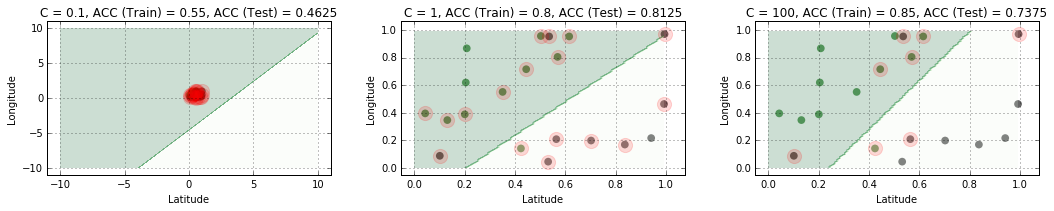

In [11]:
# Load train data
data_train = np.loadtxt("datasets/dataset_2_train.txt", delimiter=',')
x_train = data_train[:, 0:-1]
y_train = data_train[:, -1]

# Load test data
data_test = np.loadtxt("datasets/dataset_2_test.txt", delimiter=',')
x_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

# Fit and plot for different 'C' values
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 0.1, ax[0], (-10, 10))

ax[1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 1, ax[1])

ax[2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 100, ax[2])

plt.tight_layout()

For `dataset_2`, any linear decision boundary would have some errors. In this case, SVM chooses a decision boundary by trading-off the errors for margin (i.e. balancing minimizing error with maximizing margin). It appears that the parameter $C$ controls the trade-off. 

Increasing $C$ lays more emphasis on accuracy and less emphasis on the margin of separation. As a result, the model tends to overfit the train set, and perform poorly on the test set.

For $C=0.01$, the model clearly underfits the train set. For $C=100$, the model overfits the train set. For $C=1$, the fitted model misclassifies a point in the upper left corner (which could have othwerwise been classified correctly by a linear model), and achieves higher margin.

## Step 3: Push your analysis further

### 1. How does SVM compare with the other classifiers we know

As a first step we're fitting a decision tree with different dept levels to the available datasets.

### CART fitted on dataset 1

In [12]:
# Load train data
train_1 = np.loadtxt("datasets/dataset_1_train.txt", delimiter=',')
# Load test data
test_1 = np.loadtxt("datasets/dataset_1_test.txt", delimiter=',')

Plotting CART with different depth levels. The chosen levels are 1 split, 2 splits, 4 splits and 10 splits.

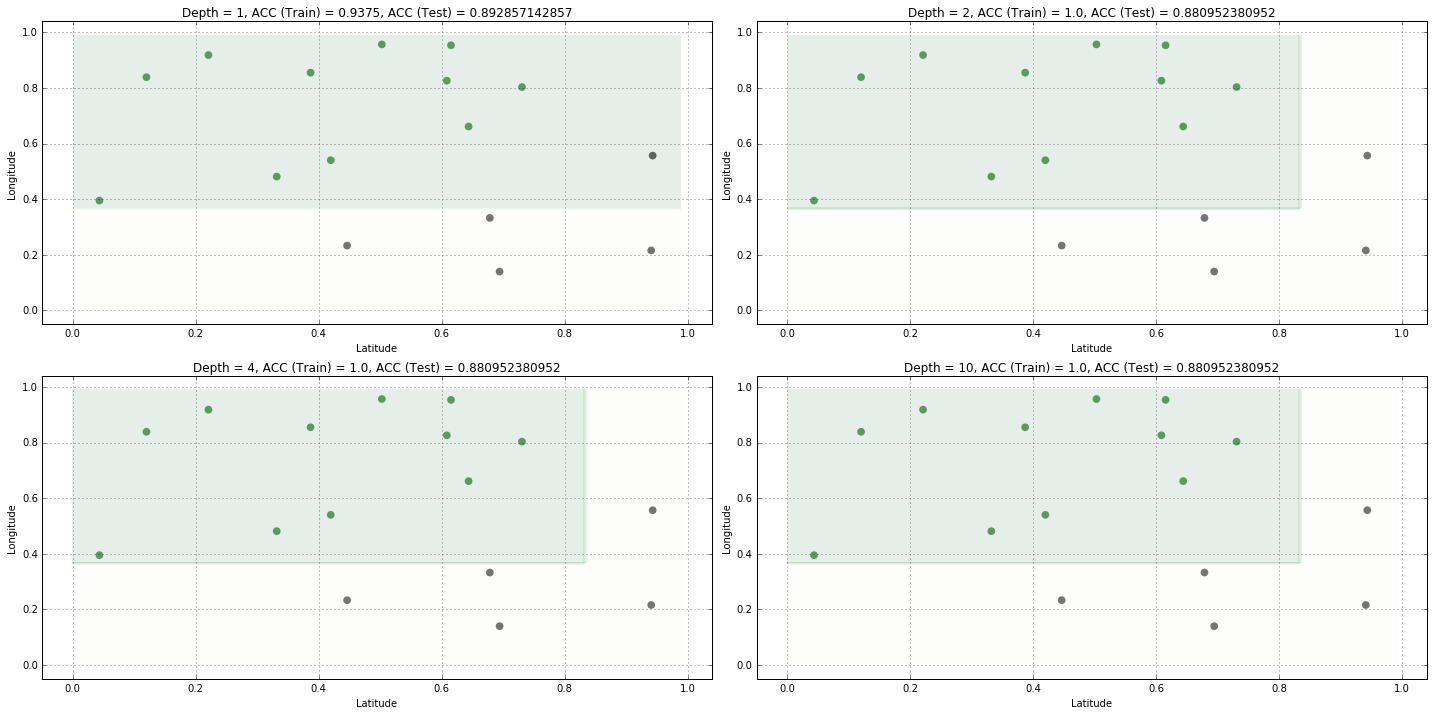

In [13]:
# Plot for dataset_1
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Plot data and decision boundary
ax[0, 0] = fit_and_plot_dt(train_1, test_1, 1, ax[0, 0]) 
ax[0, 1] = fit_and_plot_dt(train_1, test_1, 2, ax[0, 1]) 
ax[1, 0] = fit_and_plot_dt(train_1, test_1, 4, ax[1, 0]) 
ax[1, 1] = fit_and_plot_dt(train_1, test_1, 10, ax[1, 1]) 

plt.tight_layout()
plt.show()

As can be seen above, the depth levels doesn't matter. The points are always perfectly split in the dataset 1.

### CART fitted on dataset 2

In [14]:
# Load train data
train_2 = np.loadtxt("datasets/dataset_2_train.txt", delimiter=',')
# Load test data
test_2 = np.loadtxt("datasets/dataset_2_test.txt", delimiter=',')

Plotting CART with different depth levels. The chosen levels are 1 split, 2 splits, 4 splits and 10 splits.

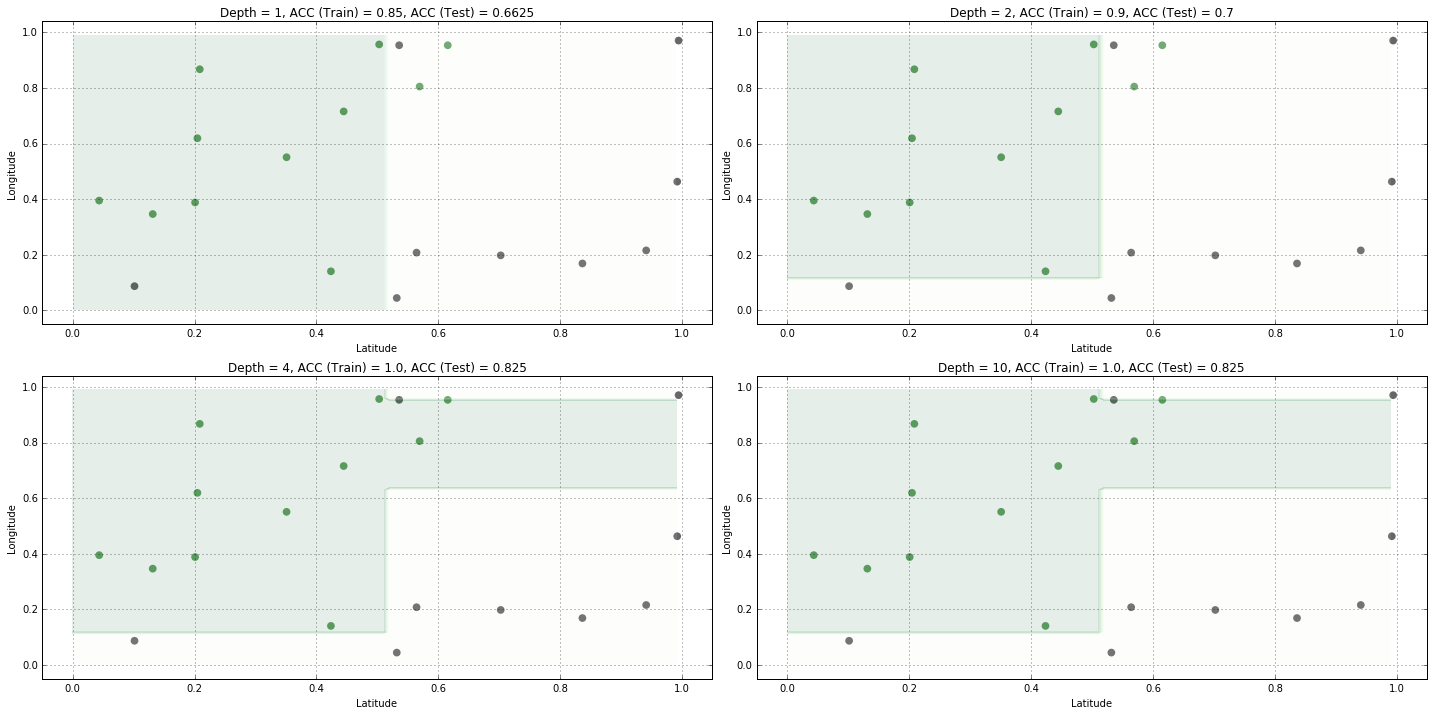

In [15]:
# Plot for dataset_2
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Plot data and decision boundary
ax[0, 0] = fit_and_plot_dt(train_2, test_2, 1, ax[0, 0]) 
ax[0, 1] = fit_and_plot_dt(train_2, test_2, 2, ax[0, 1]) 
ax[1, 0] = fit_and_plot_dt(train_2, test_2, 4, ax[1, 0]) 
ax[1, 1] = fit_and_plot_dt(train_2, test_2, 10, ax[1, 1]) 

plt.tight_layout()
plt.show()

The above plots show, that the depth of the tree matters for the decision boundary. The further down the split the closer the decision boundary to the training points.

## 2. Changing the shape of the decision boundarys

*It looks like the only decision boundaries SVM draws, so far, are lines. This is pretty limiting. Is there any way for us to change the shape of the decision boundary (how did we get logistic regression to draw curvy boundaries)?*

This can be done by transforming the feature space in a non linear fashion (polynomial). In order to do this kernels can be used. Using kernels means transforming the feature vector to fitting a support vector in a high-dimensional space.

### Kernel switching on dataset 1

Using 4 different kernels for the SVM. Those are a linear kernel, a polynomial kernel, a rbf kernel and a sigmoid kernel

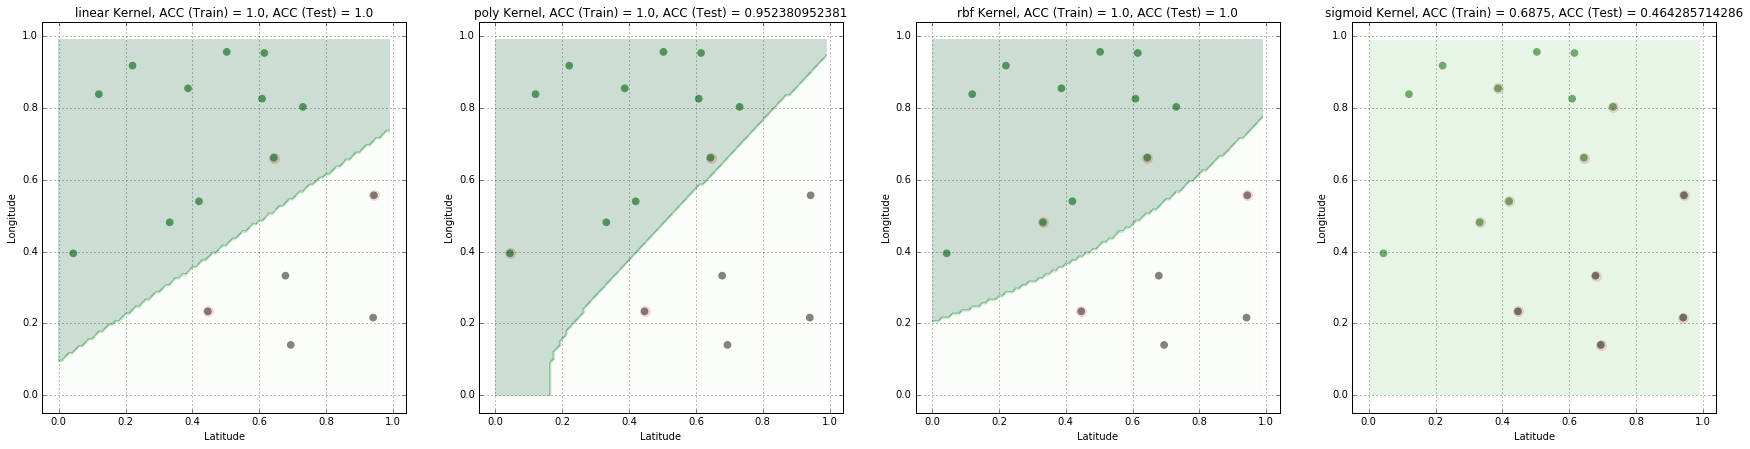

In [16]:
# Plot 4 different kernels
kernel_switcher(train_1, test_1)

### Kernel switching on dataset 2

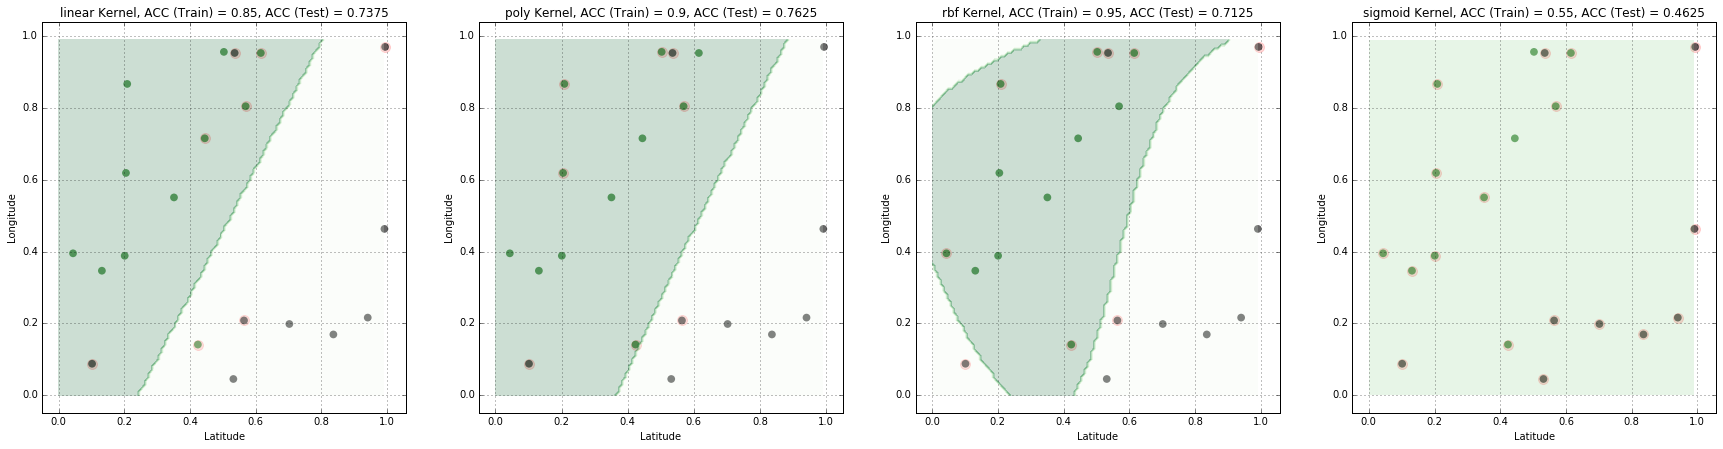

In [17]:
# Plot 4 different kernels
kernel_switcher(train_2, test_2)

## 3. Which model is better for remote senseing

**In this lab, we've only explored SVM. How does SVM compare with other classifiers in terms of addressing the challenges of remote sensing for land cover analysis?**

** Dataset 1 ** <br>
The CART classification on dataset 1 achieves a maximum test accuracy of 0.89 with a depth level of 1 compared to an accuracy of 1.0 with a linear SV and rbf kernel. The SVM performs in this setting better. 

** Dataset 2 ** <br>
On the dataset 2 the CART classifier performs the best with a depth level of 4 where it achieves an accuracy of 0.825. This in contrast to 0.7625 of the polynomial kernel of the svm. The CART tree performs for this data better. 


## 4. Comparing the results
** Compare the result of using support vector classifiers to perform classification against results obtained from other models you have learned. Which model is more appropriate for the general task of vegetation detection in aerial images (do not restrict yourself to which model performs better on just these two datasets)?**

The above results show, that when modeling vegetation it can't always be assumed that the modeled areas occure in distinct cluster. The problem with SVM's is, that they are only able to model a single decision boundary between vegetation and non-vegetation. The CART approach on the other hand can also model smaller patches of land inbetween the clusters. This is done with the depth of the tree. 


## 5. What is the most appropriate model

**Which model is more appropriate for other types of image processing (hand-writting digit classification for example)**

In order to address the topic of hand-writting digit classification I would argue that SVM's are more appropriate than using CART. The reason for this is, that SVM's are spare, which means that they only require a very small subset of the handwritting points. That means that SVM's are not affected by large datasets and less prone to the course of dimensionalty, i.e., they are more able to handly high dimensionality problems.


## 6. Drawbacks of SVM's

**Are there any obvious draw backs to support vector classifiers as we have presented them to you? What might be some intuitive ways to address these draw backs?**

Classical SVM's have a linear kernel and can only cut the hyperplane in a linear fashion. This was for example addressed by Burgess (1998): *"Perhaps the biggest limitation of the support vector approach lies in choice of the kernel."* This can be addressed by using different kernels that are able to transform the hyperplane into complex non linear decision boundaries. 

A further drawback is presented by categorical variables. In order to solve this issue, the categorical variables can be recoded with dummy variables. 

Last but not least a further drawback is the algorithmic complexity and extensive memory requirements of the required quadratic programming in large-scale tasks. This problem can nowadays be easierd solved trough the usage of cloud computing options like AWS, Azure or others.

---

## Problem 2 (Optional): Classification Competition

I took part in the Harvard Data Science Competition competition. My rank is 6th out of 97. The link to my profile is the following: <br>
https://www.kaggle.com/timhagmann

---

## Challenge Problem: Meta Learning

In the problem, you are provided with 10 different previously trained prediction models for a spam classification task. The task is to investigate how can one combine these models into a single meta classification model (without retraining the individual models) that performs better than each of the individual ones? 


## Functions (necessary for the following calculations)

In [18]:
#--------  find_mode
# Generate for the test set a mode prediction. 
# Input: 
#      row (define the row)

def find_mode(row_index):
    counts = np.unique(row_index, return_counts=True)[1]

    if (len(counts) == 2 and counts[0] == counts[1]):
        if np.random.random() >0.5:
            return counts[0]
        return counts[1]
    
    return np.argmax(counts)

## Load data and models

The data for this problem is provided in the files `dataset_5_train.txt` and `dataset_5_test.txt`. Each row of these files is an email described by 57 attributes, and the last column is 1 if the email is spam, and 0 otherwise. 

The prediction models are provided in the file `models.npy` and can be loaded into an array by executing: 

`models = np.load('models.npy')`

In [19]:
# Load models from the npy file
models = np.load('models.npy')

# Load train and test dataframe
train_5 = np.loadtxt('datasets/dataset_5_train.txt', delimiter=',')
test_5 =  np.loadtxt('datasets/dataset_5_test.txt', delimiter=',')

Extract the x and y variables

In [20]:
# Extract x and y variables
x_train = train_5[:, 0:-1]
y_train = train_5[:, -1]

x_test = test_5[:, 0:-1]
y_test = test_5[:, -1]

## Make predictions

As before, you can make predictions using the $i^\text{th}$ using:

`model[i].predict(x_test)` 

and score the model using:

`model[i].score(x_test, y_test)`

In [21]:
# Get a n x 10 prediction matrix of the training and testing testing set of the model
pred_train = np.zeros((x_train.shape[0], len(models)))
pred_test = np.zeros((x_test.shape[0], len(models)))

for i in range(len(models)):
    pred_train[:, i] = models[i].predict(x_train)
    pred_test[:, i] = models[i].predict(x_test)

## Create a baseline model

The baseline for this task is a simple combination strategy that takes a majority vote from the individual prediction models.

In [22]:
# Find mode vectories with apply
majority_vote = np.apply_along_axis(find_mode, axis=1, arr=pred_test)
baseline_accuracy = np.mean(majority_vote == y_test)

Printing the accuracy score:

In [23]:
print 'Majority vote for the baseline accuracy:', round(baseline_accuracy * 100, 2), '%'

Majority vote for the baseline accuracy: 77.87 %


The majority vote baseline ensemble model reaches a accouracy of 77.87% that should be beaten by the following ensemble model. 

## Create an ensemble model

There are three very popular methods for combining predictions  from different models. Those are:

- **Bagging:** Building multiple models (typically of the same type) from different subsamples of the training dataset.
- **Boosting:** Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the chain.
- **Stacking:** Building multiple models (typically of differing types) and supervisor model that learns how to best combine the predictions of the primary models.

The here used approach falls into the category of stacking. A good approach to do this is to use a GLM or logistic regression on the predictions from the 10 models. The resulting response is the y variable that indicates if an email is classified as spam or not.

Building a glm on the training data leads to the coefficients for each of the predictors that gives "weights" to the prediction generadet by the seperated models. 

In [24]:
# Logistic ensemble model
log_model = LogisticRegression().fit(pred_train, y_train)
test_y_pred = log_model.predict(pred_test)
log_model_accuracy = np.mean(test_y_pred == y_test)


Printing the accuracy score:

In [25]:
print 'Ensemble model accuracy score:', round(log_model_accuracy * 100, 2), '%'

Ensemble model accuracy score: 89.6 %


The combined ensemble model build with a GLM gives an accuracy score of 89.6% which is better that the baseline score. 

---